### 1. Introduction

Credit default prediction is central to managing risk in a consumer lending business. Credit default prediction allows lenders to optimize lending decisions, which leads to a better customer experience and sound business economics. Current models exist to help manage risk. But it's possible to create better models that can outperform those currently in use.

In this notebook, I will use machine learning to predict credit default. I will leverage an industrial scale data set to build a machine learning model that challenges the current model in production. Training, validation, and testing datasets include time-series behavioral data and anonymized customer profile information.

The objective is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables
with the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

The goal is to predict, for each customer_ID, the probability of a future payment default (target = 1).

Note. The negative class has been subsampled for this dataset at 5%, and thus receives a 20x weighting in the scoring metric.

### 2. Key Findings

- 26% of customers in the training data have defaulted. We know that the negative class (good customers) have been subsampled by a factor of 20. Because of the class imbalance, I will use StratifiedKFold for cross validation.

- There is a significant number of missing data. Many decision-tree based algorithms can deal with missing values. With decision-tree models, there is no need to change the missing values. Neural networks can not deal with missing values. So I need to impute values for NNs.

- 80%, of customers have 13 statements. The remaining 20% of the customers have 1 to 12 statements. I will model only the last statement using decision-tree models. For time-series modelling, I will only include customers that have 13 statements.

- According to the competition data description, there are eleven categorical features. I plot histograms for target=0 and target=1. We will see that the distributions are different for target=0 and target=1. This shows that there is information in the categorical variables about the target.

### 3. Import libraries

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
pd.set_option('display.max_columns', None)

### 4. Load Data

In [2]:
train_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv')
train_labels.head()

customer_ID  target
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       0
1  00000fd6641609c6ece5454664794f0340ad84dddce9a2...       0
2  00001b22f846c82c51f6e3958ccd81970162bae8b007e8...       0
3  000041bdba6ecadd89a52d11886e8eaaec9325906c9723...       0
4  00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...       0

The dataset of this competition has a considerable size. If I read the original csv files, the data barely fits into memory. That's why I read the data from @munumbutt's AMEX-Feather-Dataset. In this Feather file, the floating point precision has been reduced from 64 bit to 16 bit. And reading a Feather file is faster than reading a csv file because the Feather file format is binary.

In [3]:
train_data = pd.read_feather('../input/amexfeather/train_data.ftr')
test_data = pd.read_feather('../input/amexfeather/test_data.ftr')
train_data.head()

customer_ID        S_2       P_2  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f... 2017-03-09  0.938477   
1  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f... 2017-04-07  0.936523   
2  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f... 2017-05-28  0.954102   
3  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f... 2017-06-13  0.960449   
4  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f... 2017-07-16  0.947266   

       D_39       B_1       B_2       R_1       S_3      D_41       B_3  D_42  \
0  0.001734  0.008728  1.006836  0.009224  0.124023  0.008774  0.004707   NaN   
1  0.005775  0.004925  1.000977  0.006153  0.126709  0.000798  0.002714   NaN   
2  0.091492  0.021652  1.009766  0.006817  0.123962  0.007599  0.009422   NaN   
3  0.002455  0.013687  1.002930  0.001372  0.117188  0.000685  0.005531   NaN   
4  0.002483  0.015190  1.000977  0.007607  0.117310  0.004654  0.009308   NaN   

   D_43      D_44       B_4      D_45       B_5       R_2      D_46      D_47  \
0   NaN  0.000630  0.080994  0.708984  0.170654  0.006203  0.358643  0.525391   
1   NaN  0.002525  0.069397  0.712891  0.113220  0.006207  0.353516  0.521484   
2   NaN  0.007607  0.068848  0.720703  0.060486  0.003260  0.334717  0.524414   
3   NaN  0.006405  0.055634  0.724121  0.166748  0.009918  0.323242  0.530762   
4   NaN  0.007732  0.038849  0.720703  0.143677  0.006668  0.230957  0.529297   

       D_48  D_49       B_6       B_7       B_8      D_50      D_51       B_9  \
0  0.255615   NaN  0.063904  0.059418  0.006466  0.148682  1.335938  0.008209   
1  0.223389   NaN  0.065247  0.057739  0.001614  0.149780  1.339844  0.008369   
2  0.189453   NaN  0.066956  0.056641  0.005127  0.151978  1.336914  0.009354   
3  0.135620   NaN  0.083740  0.049255  0.001417  0.151245  1.339844  0.006783   
4       NaN   NaN  0.075928  0.048920  0.001199  0.154053  1.341797  0.000519   

        R_3      D_52       P_3      B_10  D_53       S_5      B_11       S_6  \
0  0.001423  0.207275  0.736328  0.096191   NaN  0.023376  0.002768  0.008324   
1  0.001984  0.202759  0.720703  0.099792   NaN  0.030594  0.002748  0.002481   
2  0.007427  0.206665  0.738281  0.134033   NaN  0.048370  0.010078  0.000530   
3  0.003515  0.208252  0.741699  0.134399   NaN  0.030060  0.009666  0.000783   
4  0.001362  0.205444  0.691895  0.121521   NaN  0.054230  0.009483  0.006699   

       D_54       R_4       S_7      B_12       S_8      D_55      D_56  \
0  1.001953  0.008301  0.161377  0.148315  0.922852  0.354492  0.151978   
1  1.008789  0.005135  0.140991  0.143555  0.919434  0.326660  0.156250   
2  1.008789  0.006962  0.112244  0.136963  1.001953  0.304199  0.153809   
3  1.007812  0.008705  0.102844  0.129028  0.704102  0.275146  0.155762   
4  1.003906  0.003845  0.094299  0.129517  0.916992  0.231079  0.154907   

       B_13       R_5      D_58       S_9      B_14      D_59      D_60  \
0  0.118103  0.001882  0.158569  0.065735  0.018387  0.063660  0.199585   
1  0.118713  0.001610  0.148438  0.093933  0.013039  0.065491  0.151367   
2  0.114563  0.006329  0.139526  0.084778  0.056641  0.070618  0.305908   
3  0.120728  0.004978  0.138062  0.048370  0.012497  0.065918  0.273438   
4  0.095154  0.001654  0.126465  0.039246  0.027893  0.063721  0.233154   

       D_61      B_15      S_11      D_62 D_63 D_64      D_65      B_16  B_17  \
0  0.308350  0.016357  0.401611  0.091064   CR    O  0.007126  0.007664   NaN   
1  0.265137  0.017685  0.406250  0.086792   CR    O  0.002413  0.007149   NaN   
2  0.212158  0.063965  0.406738  0.093994   CR    O  0.001878  0.003637   NaN   
3  0.204346  0.022736  0.405273  0.094849   CR    O  0.005898  0.005894   NaN   
4  0.175659  0.031174  0.487549  0.093933   CR    O  0.009476  0.001715   NaN   

       B_18      B_19 D_66      B_20 D_68      S_12       R_6      S_13  \
0  0.652832  0.008522  NaN  0.004730  6.0  0.271973  0.008362  0.515137   
1  0.646973  0.002237  NaN  0.003880  6.0  0.188965  0.004028  0.509277   
2  0.645996  0.0

### 5. Exploratory Data Analysis

These are the categorical features based on the compeition description.

In [4]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

print(f"There are {train_data.shape[1]-1} features in the data. {len(cat_features)} of them are categorical features.")

There are 190 features in the data. 11 of them are categorical features.


In [5]:
print(f"There are {train_data.shape[0]/1000000} million rows in the training data and {test_data.shape[0]/1000000} million rows in the test data.")
print(f"There are {train_data.customer_ID.nunique()} unique customers in the training data.")

There are 5.531451 million rows in the training data and 11.363762 million rows in the test data.
There are 458913 unique customers in the training data.


In [22]:
print(f"There are {train_labels.shape[0]} customer_IDs in the train_labels.")
print(f"There are {train_labels.isna().sum().sum()} missing data and {train_labels.customer_ID.duplicated().sum()} duplicated customer_IDs in the train_labels.")

There are 458913 customer_IDs in the train_labels.
There are 0 missing data and 0 duplicated customer_IDs in the train_labels.


### 5.1. Target Variable

The goal of the competition is to use monthly customer historical data to estimate the probability of default, i.e. failing to pay the credit card bills within the 18 months after the latest statement.

Let's look at the distribution of target variable.


In [30]:
print(f"Out of the {train_labels.shape[0]} customers, {train_labels['target'].value_counts().iloc[1]} customers have defaulted.")

Out of the 458913 customers, 118828 customers have defaulted.


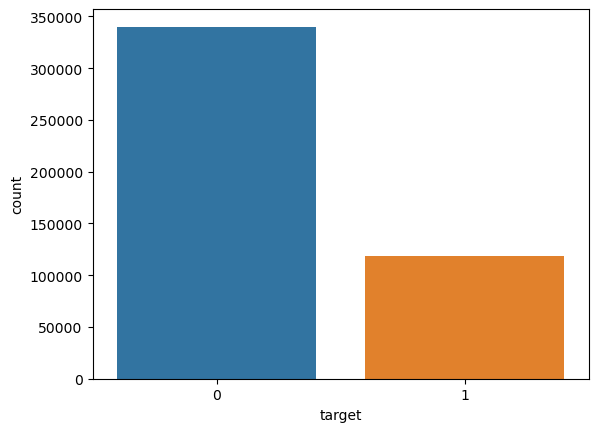

In [5]:
sns.countplot(x=train_labels.target)
plt.show()

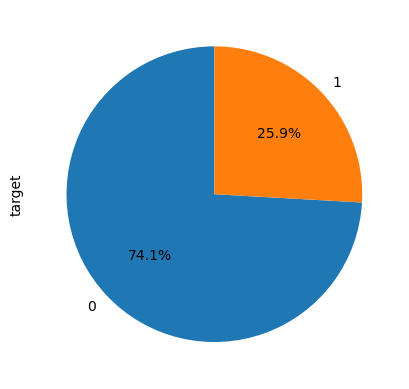

In [12]:
train_labels['target'].value_counts().plot(kind = 'pie',autopct='%1.1f%%', startangle=90)
plt.show()

### Key Insights:
- 25.9% of the training data has target value of 1 (bad customers). The classes are imbalanced. Balanced accuracy is particularly useful here, since the classes are not represented equally. Regular accuracy may not be an accurate metric to evaluate the performance of a classification model.

- Stratified K-Fold cross-validation is useful for this dataset, since the classes are imbalanced. Stratified K-Fold cross-validation ensures that each fold retains the same class distribution as the original dataset, thus providing a more representative estimate of the model's performance.

### 5.2. Missing Data Analysis

There is a significant number of missing data. It is not reasonable to drop all columns or rows that have a missing value.

Many decision-tree based algorithms can deal with missing values. With decision-tree models, I don't need to change the missing values. Neural networks can not deal with missing values. So I need to impute values for NNs.

Let's look at the top 30 columns with the most null values.

In [6]:
null= pd.DataFrame(train_data.isnull().sum(),columns=['number_of_nulls'])
null['percentage_of_null'] = round(((null['number_of_nulls']/len(train_data))*100) , 2)
null = null[null['number_of_nulls']>0]
null= null.sort_values(by='percentage_of_null',ascending=False)
null.head(30)

number_of_nulls  percentage_of_null
D_87           5527586               99.93
D_88           5525447               99.89
D_108          5502513               99.48
D_110          5500117               99.43
D_111          5500117               99.43
B_39           5497819               99.39
D_73           5475595               98.99
B_42           5459973               98.71
D_134          5336752               96.48
D_137          5336752               96.48
D_138          5336752               96.48
D_135          5336752               96.48
D_136          5336752               96.48
R_9            5218918               94.35
B_29           5150035               93.10
D_106          4990102               90.21
D_132          4988874               90.19
D_49           4985917               90.14
R_26           4922146               88.98
D_76           4908954               88.75
D_66           4908097               88.73
D_42           4740137               85.69
D_142          4587043               82.93
D_53           4084585               73.84
D_82           4058614               73.37
D_50           3142402               56.81
B_17           3137598               56.72
D_105          3021431               54.62
D_56           2990943               54.07
S_9            2933643               53.04

Most of the top null columns are delinquency features.

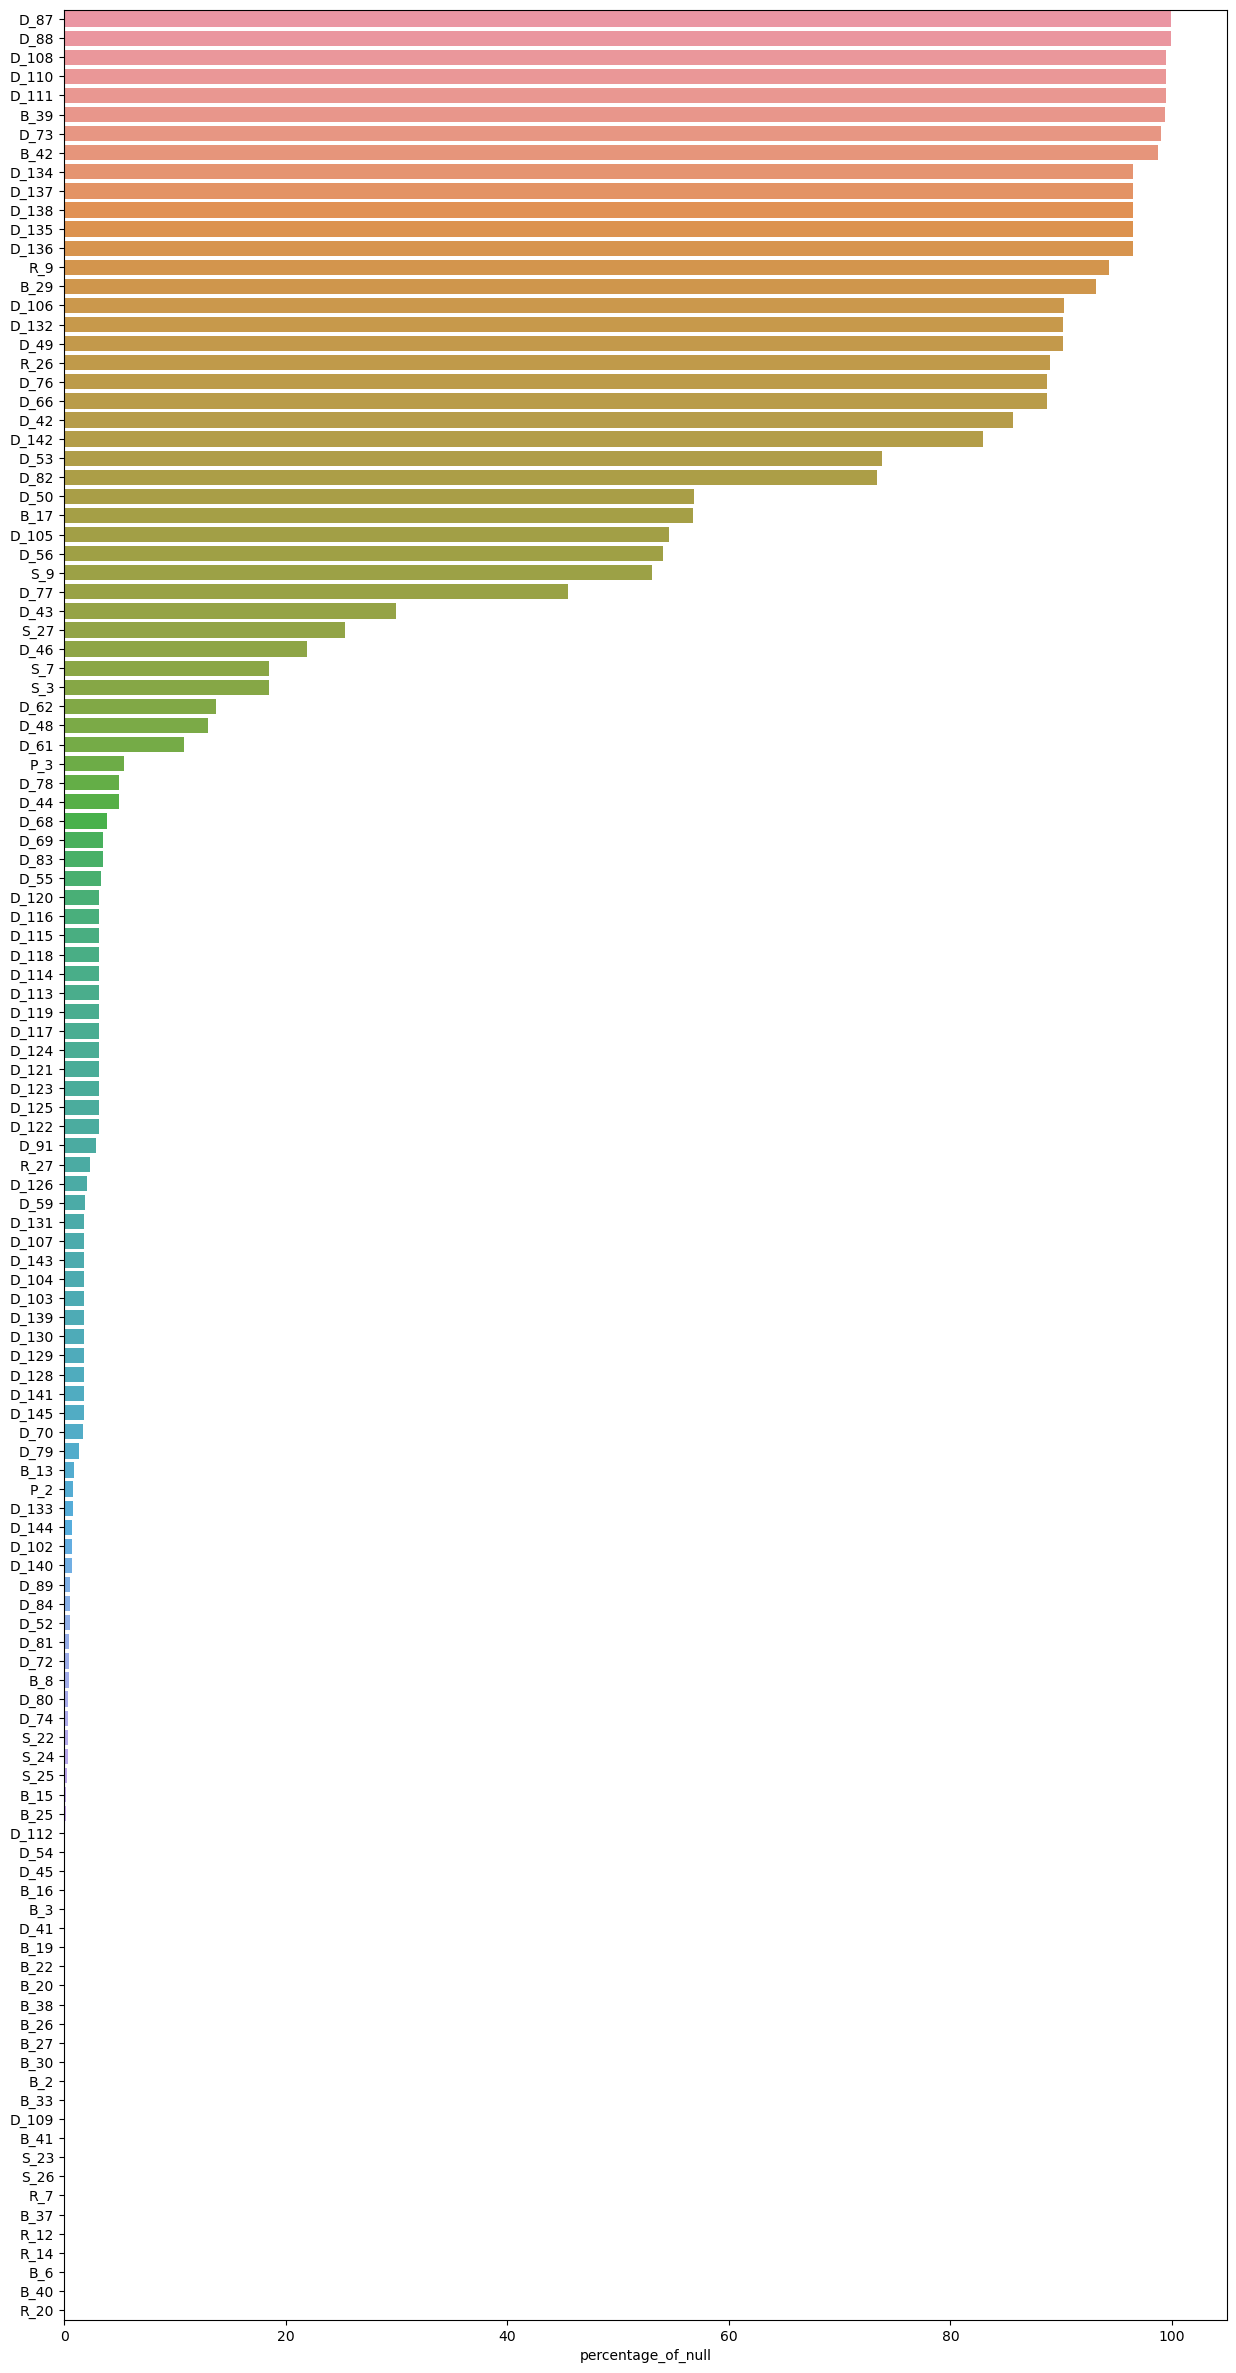

In [36]:
fig = plt.figure(figsize=(15,30))
sns.barplot(data=null,y=null.index,x=null['percentage_of_null'])
del null

### Key Insights

- There are many missing values, especially in the delinquency variables, with D_87 having the highest number of nulls (99.93%).

- Decision-tree models are attractive to use for this dataset, since they handle null values.

### 5.3. Customer Profiles

Let's check the number of credit card statements over time. We see that statement dates range from March 2017 to March 2018 in the train data and from April 2018 to October 2019 in the test data.

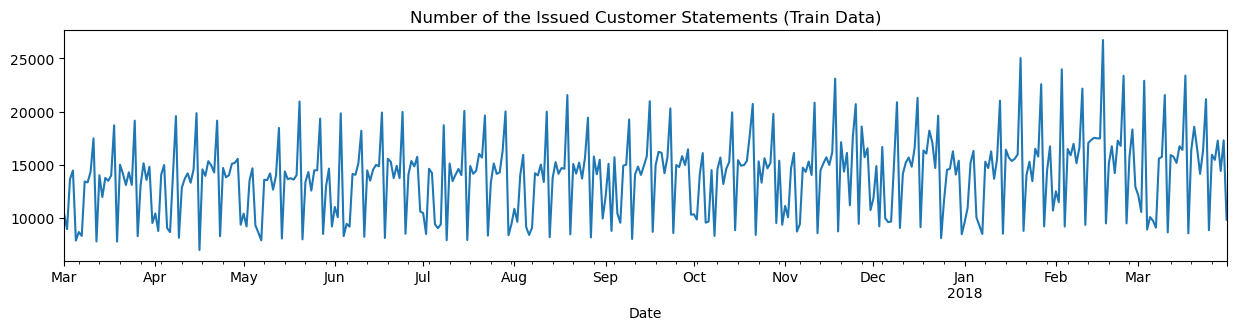

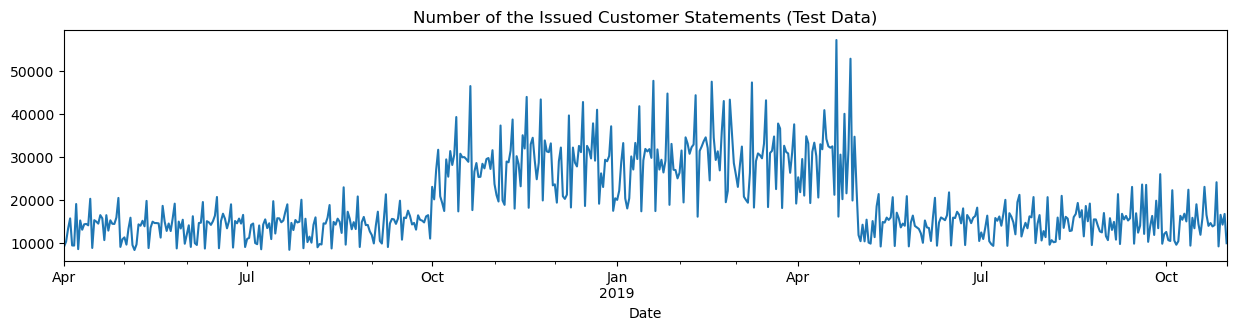

In [10]:
fig, ax = plt.subplots(figsize=(15,3))
train_data.groupby("S_2")['customer_ID'].count().plot()
plt.title("Number of the Issued Customer Statements (Train Data)")
plt.xlabel('Date')
plt.show()

fig2, ax2 = plt.subplots(figsize=(15,3))
test_data.groupby("S_2")['customer_ID'].count().plot()
plt.xlabel('Date')
plt.title("Number of the Issued Customer Statements (Test Data)")
plt.show()

Lets count how many credit card statements there are per customer. Most customers have 13 statements and others have 1 to 12 statements.
This means that the model has to handle a variable number of statements per customer.

Text(0.5, 1.0, 'Num of Statements per Customer (Test Data)')

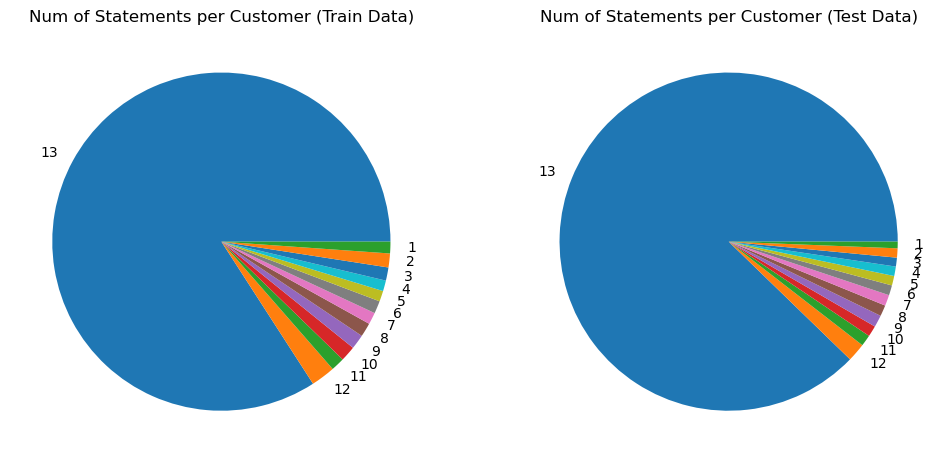

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
train_data_value_counts = train_data.customer_ID.value_counts().value_counts().sort_index(ascending=False)
test_data_value_counts = test_data.customer_ID.value_counts().value_counts().sort_index(ascending=False)

ax1.pie(train_data_value_counts, labels=train_data_value_counts.index)
ax1.set_title('Num of Statements per Customer (Train Data)')

ax2.pie(test_data_value_counts, labels=test_data_value_counts.index)
ax2.set_title('Num of Statements per Customer (Test Data)')

Let's see when customers received their last statements. The histogram of the last statement dates shows that every train customer got his last statement in March of 2018. Half of the test customer got their last statement in April 2019 and half in October 2019.

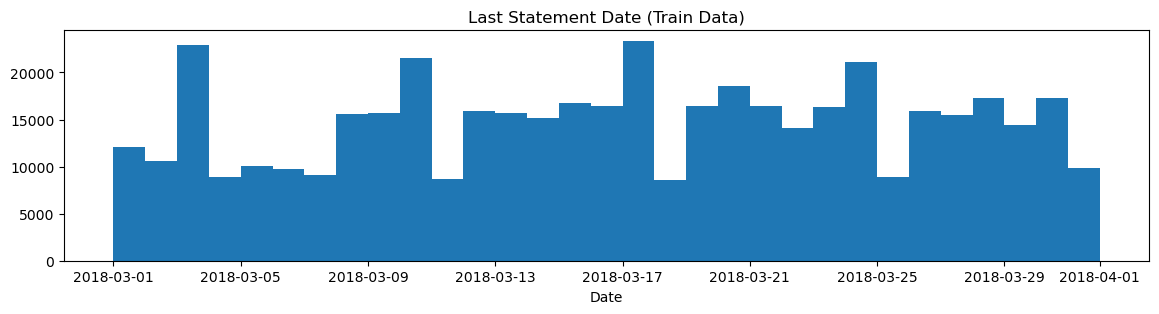

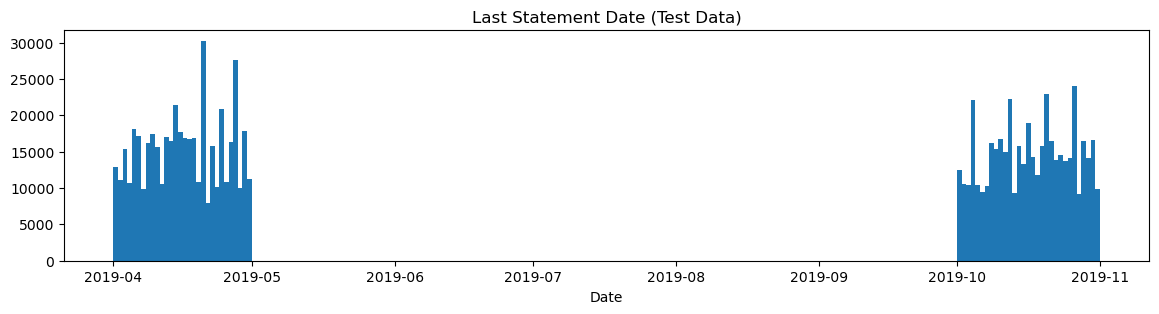

In [14]:
plt.figure(figsize=(14, 3))
plt.hist(train_data.S_2.groupby(train_data.customer_ID).max(), bins=pd.date_range("2018-03-01", "2018-04-01", freq="d"))
plt.title('Last Statement Date (Train Data)', fontsize=12)
plt.xlabel('Date')
plt.show()

plt.figure(figsize=(14, 3))
plt.hist(test_data.S_2.groupby(test_data.customer_ID).max(), bins=pd.date_range("2019-04-01", "2019-11-01", freq="d"))
plt.title('Last Statement Date (Test Data)', fontsize=12)
plt.xlabel('Date')
plt.show()

There is no overlap between the dates in the train and the test data.

In [57]:
train_data['S_2'] = pd.to_datetime(train_data['S_2'])
test_data['S_2'] = pd.to_datetime(test_data['S_2'])

print(f"Train Data Min Date: {train_data['S_2'].min()}, Max Date: {train_data['S_2'].max()}")
print(f"Train Data Min Date: {test_data['S_2'].min()}, Max Date: {test_data['S_2'].max()}")

Train Data Min Date: 2017-03-01 00:00:00, Max Date: 2018-03-31 00:00:00
Train Data Min Date: 2018-04-01 00:00:00, Max Date: 2019-10-31 00:00:00


The following histogram plot shows that the first and last statement for most customers is about a year apart. Most customers have 13 statements. This indicates that the customers usually get one statement per month.


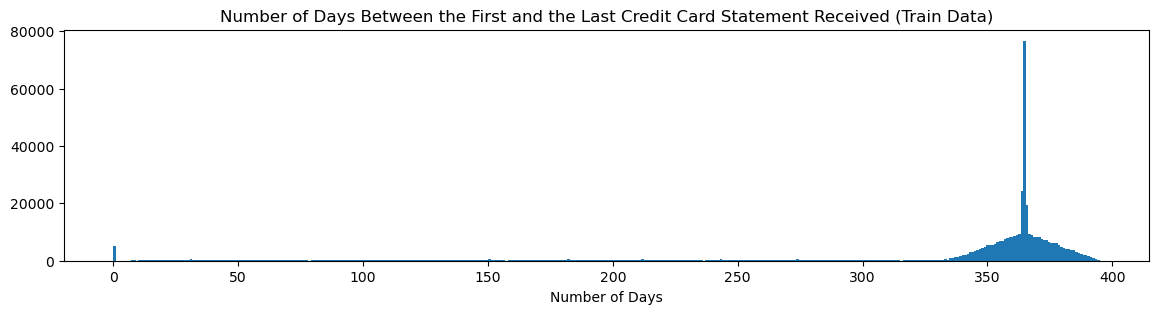

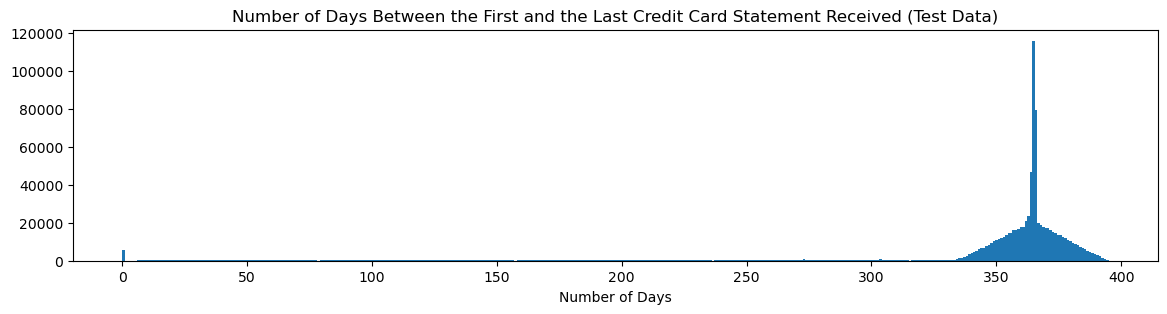

In [66]:
temp = train_data.S_2.groupby(train_data.customer_ID).agg(['max', 'min'])
plt.figure(figsize=(14, 3))
plt.hist((temp['max'] - temp['min']).dt.days, bins=400)
plt.xlabel('Number of Days')
plt.title('Number of Days Between the First and the Last Credit Card Statement Received (Train Data)')
plt.show()

temp = test_data.S_2.groupby(test_data.customer_ID).agg(['max', 'min'])
plt.figure(figsize=(14, 3))
plt.hist((temp['max'] - temp['min']).dt.days, bins=400)
plt.xlabel('Number of Days')
plt.title('Number of Days Between the First and the Last Credit Card Statement Received (Test Data)')
plt.show()
del temp

### Key Insights:

- The model will have to handle a variable-sized number of statements per customer, unless we only model the most recent statement or take an average.

- The data is a time series, however all training happens in the same month. This makes it harder to cross-validate.

### 5.4 Visualization of Categorical Features

There are eleven categorical features. I will plot histograms for target=0 and target=1.

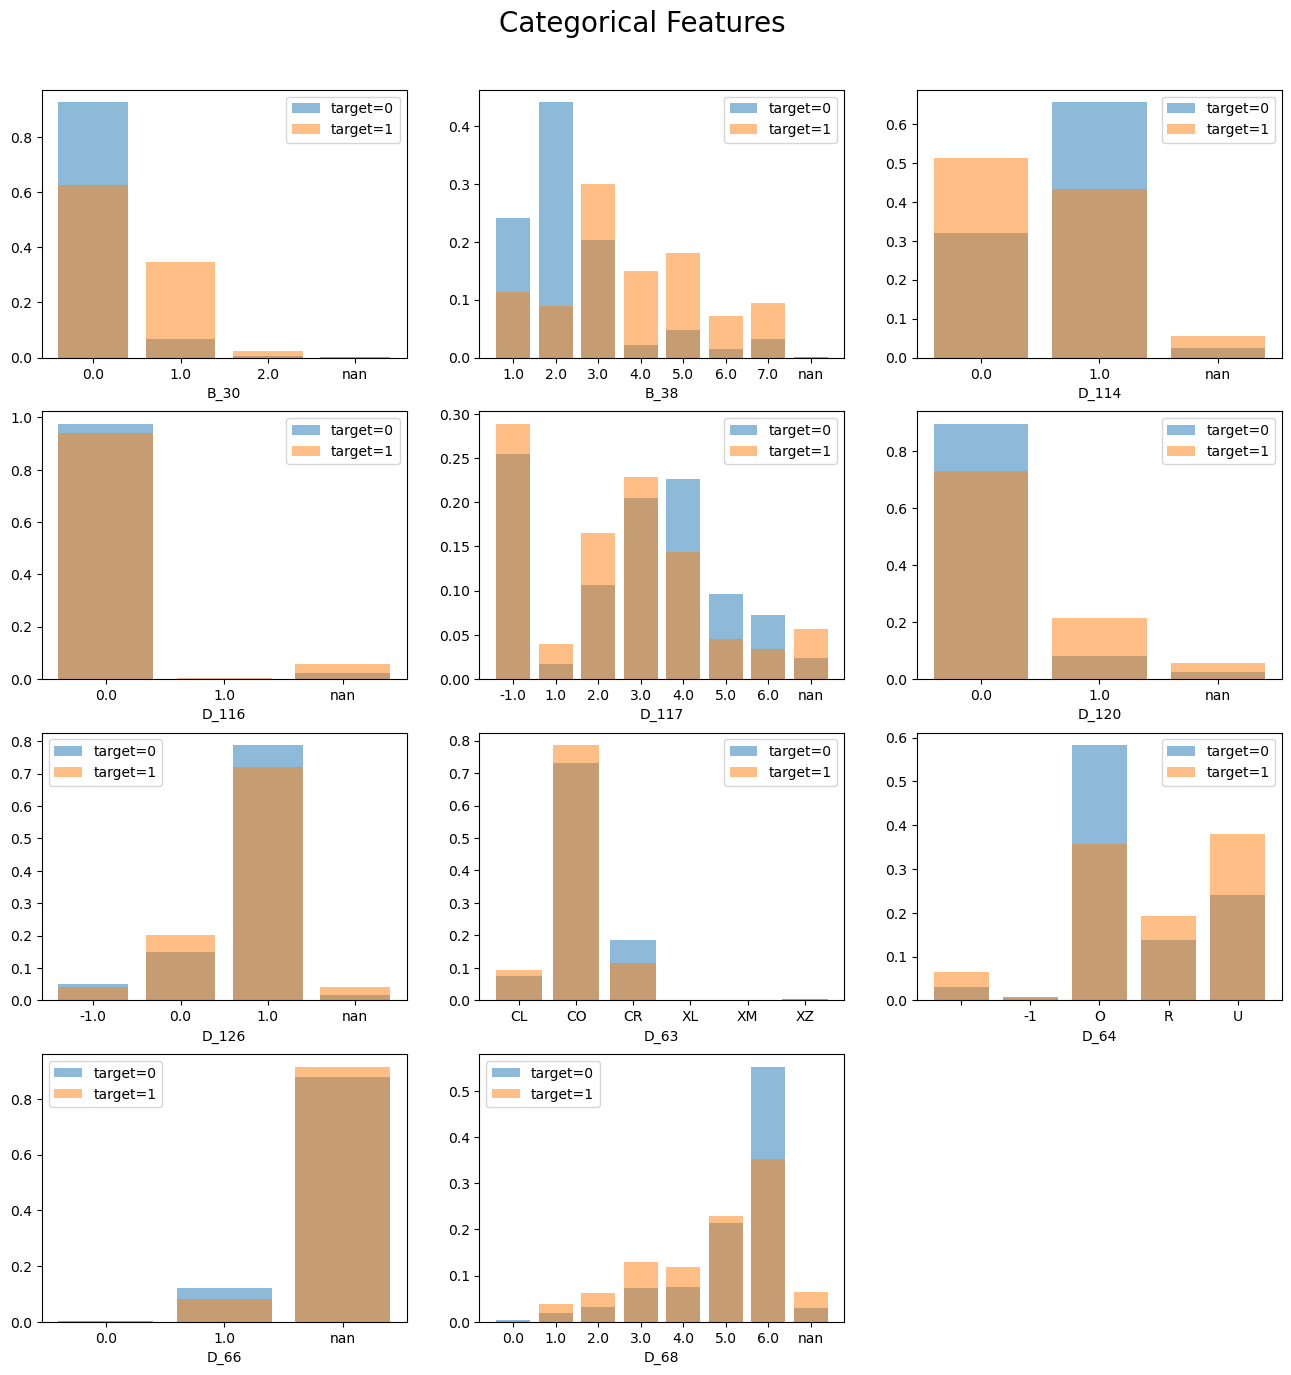

In [67]:
plt.figure(figsize=(16, 16))
for i, f in enumerate(cat_features):
    plt.subplot(4, 3, i+1)
    temp = pd.DataFrame(train_data[f][train_data.target == 0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')
    temp = pd.DataFrame(train_data[f][train_data.target == 1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')
    plt.xlabel(f)
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.suptitle('Categorical Features', fontsize=20, y=0.93)
plt.show()
del temp


In [36]:
# Null values in the categorical features

train_data[cat_features].isnull().sum().sort_values(ascending=False)

D_66     4908097
D_68      216503
D_114     176716
D_116     176716
D_117     176716
D_120     176716
D_126     116816
B_30        2016
B_38        2016
D_63           0
D_64           0
dtype: int64

### Key Insights:

- Every categorical feature has at most eight categories. It is possible to use One-hot encoding. I will explore one-hot encoding and ordical enocding in my modelling notebook.

- The distributions for target=0 and target=1 are different. This indicates that the categorical features gives some information about the target. It is worth exploring modelling the categorical variables.

- The following features are binary (they only take values of 0, 1 or missing): D_114, D_116, D_120, D_66.


### 5.5. Visualization of Numerical Features

### 5.5.1. Delinquency Variables

In [9]:
print(f"Number of delinquency features: {len([f for f in train_data.columns if (f not in  ['customer_ID', 'target', 'S_2']) and (f.startswith(('D')))])}")

delin_features = sorted([f for f in train_data.columns if (f not in cat_features + ['customer_ID', 'target', 'S_2']) and (f.startswith(('D')))])
print(f"Number of numerical delinquency features: {len(delin_features)}")

Number of delinquency features: 96
Number of numerical delinquency features: 87


In [5]:
def plot_hist(features, title):
    fig, axs = plt.subplots(int(len(features)/4)+(1 if len(features)%4!=0 else 0),4, figsize=(15,3*(int(len(features)/4)+(1 if len(features)%4!=0 else 0))))

    plt.suptitle(f'\n{title}', fontsize=20, y=1)

    for i, f in enumerate(features):
            ax = axs[int(i/4), i%4] if ((int(len(features)/4)+(1 if len(features)%4!=0 else 0))>1) else axs[i%4]
            ax.hist(train_data[f], bins=200)
            ax.set_title(f)

            # Create a smaller inset subplot within the larger subplot
            inset_ax = ax.inset_axes([0.6, 0.6, 0.35, 0.35])  # [left, bottom, width, height]
            inset_ax.hist(train_data[f], bins=200)
            inset_ax.set_ylim([0,0.001])
            inset_ax.set_yticks([])
            ax.set_yticklabels([])

    plt.tight_layout()
    plt.show()                

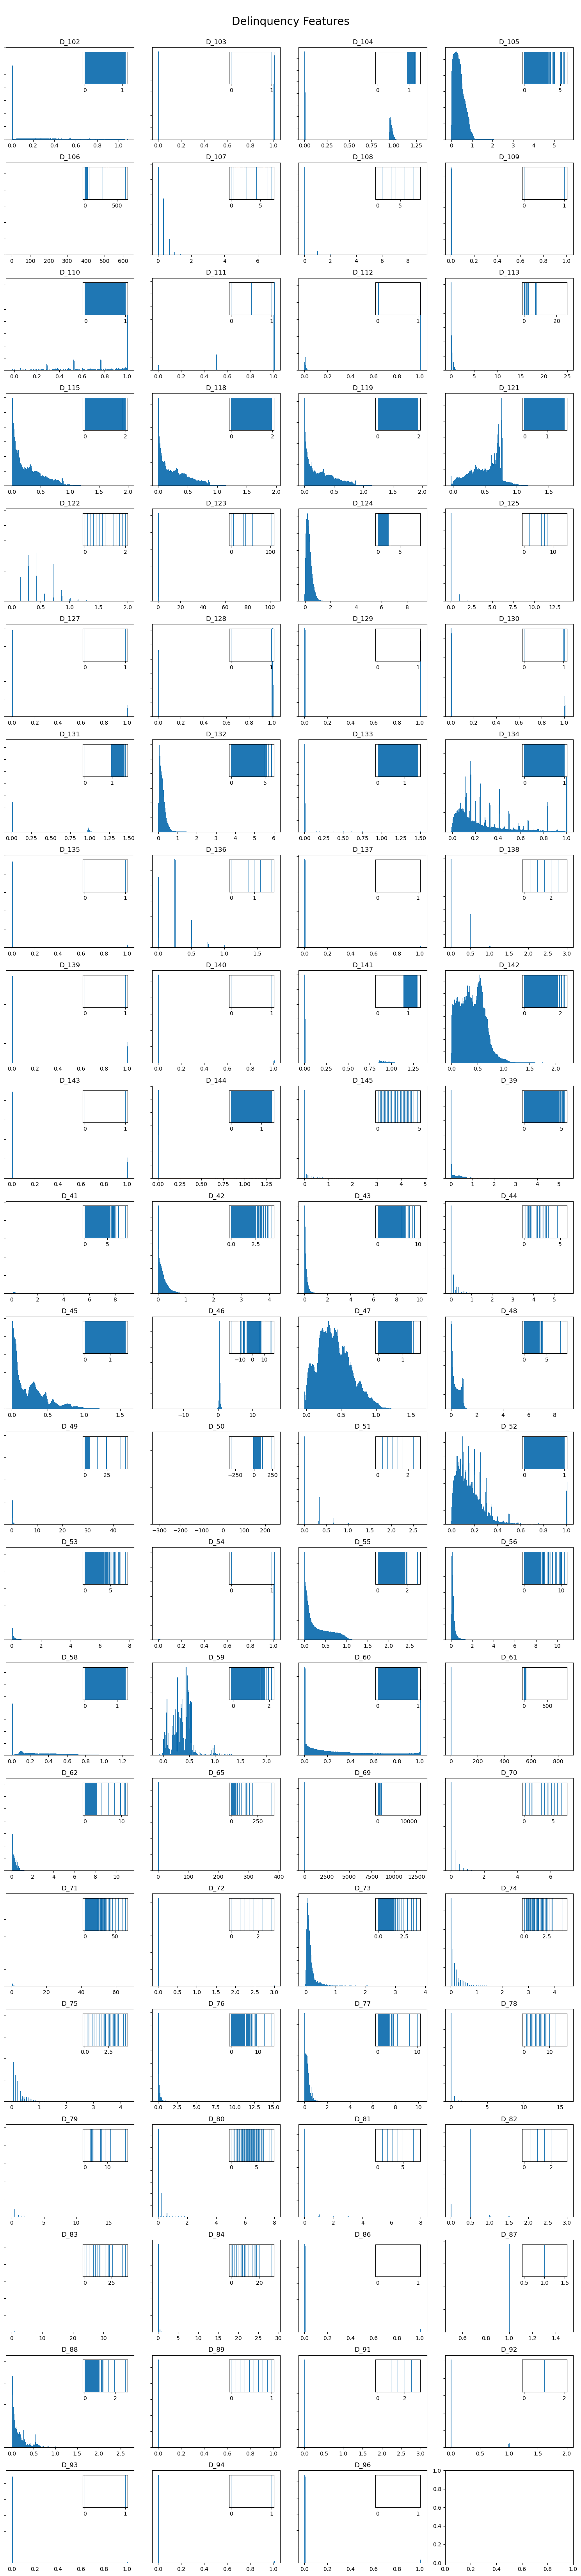

In [11]:
plot_hist(delin_features, 'Delinquency Features')

In [16]:
# Which features are discrete?

for f in delin_features:
    if(train_data[f].nunique()<15):
        print(f, train_data[f].nunique())

D_87 1


In [39]:
train_data['D_103'].nunique()

8491

Based on the histogram plots, some of features such as D_103 appear to be discrete at first. But when I zoom in on the plots, there seems to be an added noise on top of the values. For example, D-103 takes the values of [0,0.01] and [1,1.01]. This could be due to adding noise to the data to anonymize customer data by AMEX.

Text(0.5, 0, 'D_103')

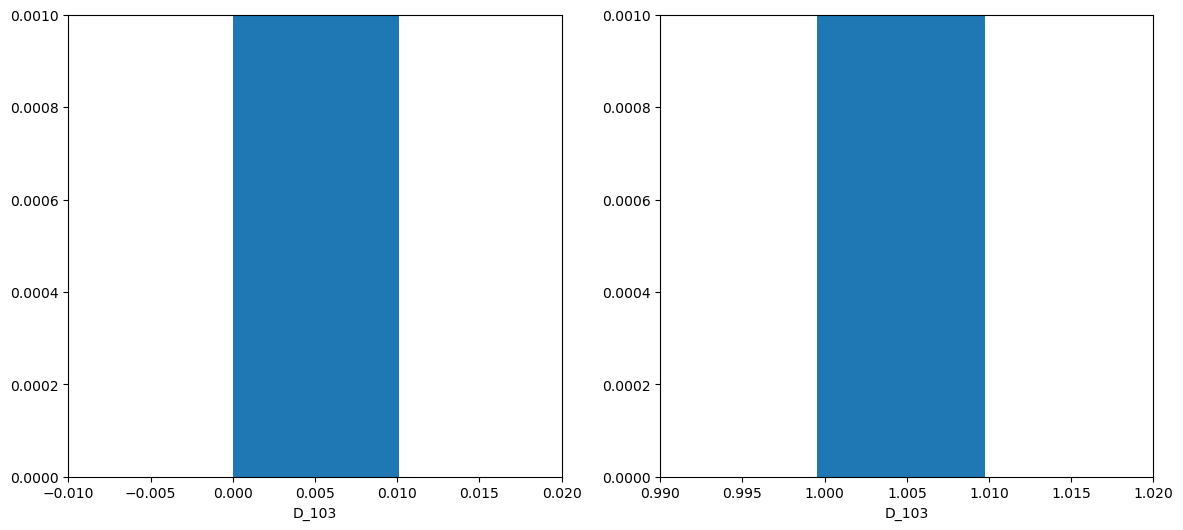

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.hist(train_data['D_103'], bins=200)
ax1.set_xlim([-0.01,0.02])
ax1.set_ylim([0,1e-3])
ax1.set_xlabel('D_103')

ax2.hist(train_data['D_103'], bins=200)
ax2.set_xlim([0.99,1.02])
ax2.set_ylim([0,1e-3])
ax2.set_xlabel('D_103')

### Key Insights:

- Some of the plots have white space at the left or right end. This may show that there aer some outliers or rare events in the data.

- It is possible to remove this added noise. This will likely result in higher model accuracy. We can use a transformatiom such as: 
train_data['D_103'] = train_data['D_103'].apply(lambda t: np.floor(t))

### Distribution of Delinquency Variables (Last Credit Card Statement)

Let's explore the kernel density estimate (KDE) plot for the delinquency variables. KDE plot visuales the distribution of data similar to a histogram, but uses a continuous probability distribution. KDE plots apply a kernel smoothing function to create a smooth probability density.

Due to the large amount of data, I was running out of memory trying to create KDE plots. So I selected the latest statement for each customer. 

In [9]:
last_statement_df = train_data.groupby('customer_ID').tail(1).set_index('customer_ID')

In [16]:
def plot_kde_last_statement(features, title):
    fig, axs = plt.subplots(int(len(features)/5)+(1 if len(features)%5!=0 else 0),5, figsize=(16,3*(int(len(features)/5)+(1 if len(features)%5!=0 else 0))))
    fig.suptitle(f'{title}\n\n',fontsize=16)
    
    for i, f in enumerate(cols[:-1]):
        ax = axs[int(i/5), i%5] if ((int(len(features)/5)+(1 if len(features)%5!=0 else 0))>1) else axs[i%5]
        sns.kdeplot(x=f, hue='target', label=['Default','Paid'], data=last_statement_df[features], fill=True, linewidth=2, legend=False, ax=ax)
        ax.set_ylabel('Density' if i%5==0 else '')

    handles, _ = axs[0,0].get_legend_handles_labels() if ((int(len(features)/5)+(1 if len(features)%5!=0 else 0))>1) else axs[0].get_legend_handles_labels()
    fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.983))
    sns.despine(bottom=True, trim=True)

    plt.tight_layout(rect=[0, 0.2, 1, 0.99])
    plt.show()

In [14]:
!pip uninstall seaborn -y
!pip install seaborn==0.11.2

Found existing installation: seaborn 0.12.2
Uninstalling seaborn-0.12.2:
  Successfully uninstalled seaborn-0.12.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 5.9 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you have scipy 1.11.1 which is incompatible.


In [1]:
import seaborn as sns
sns.__version__

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'0.11.2'

/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


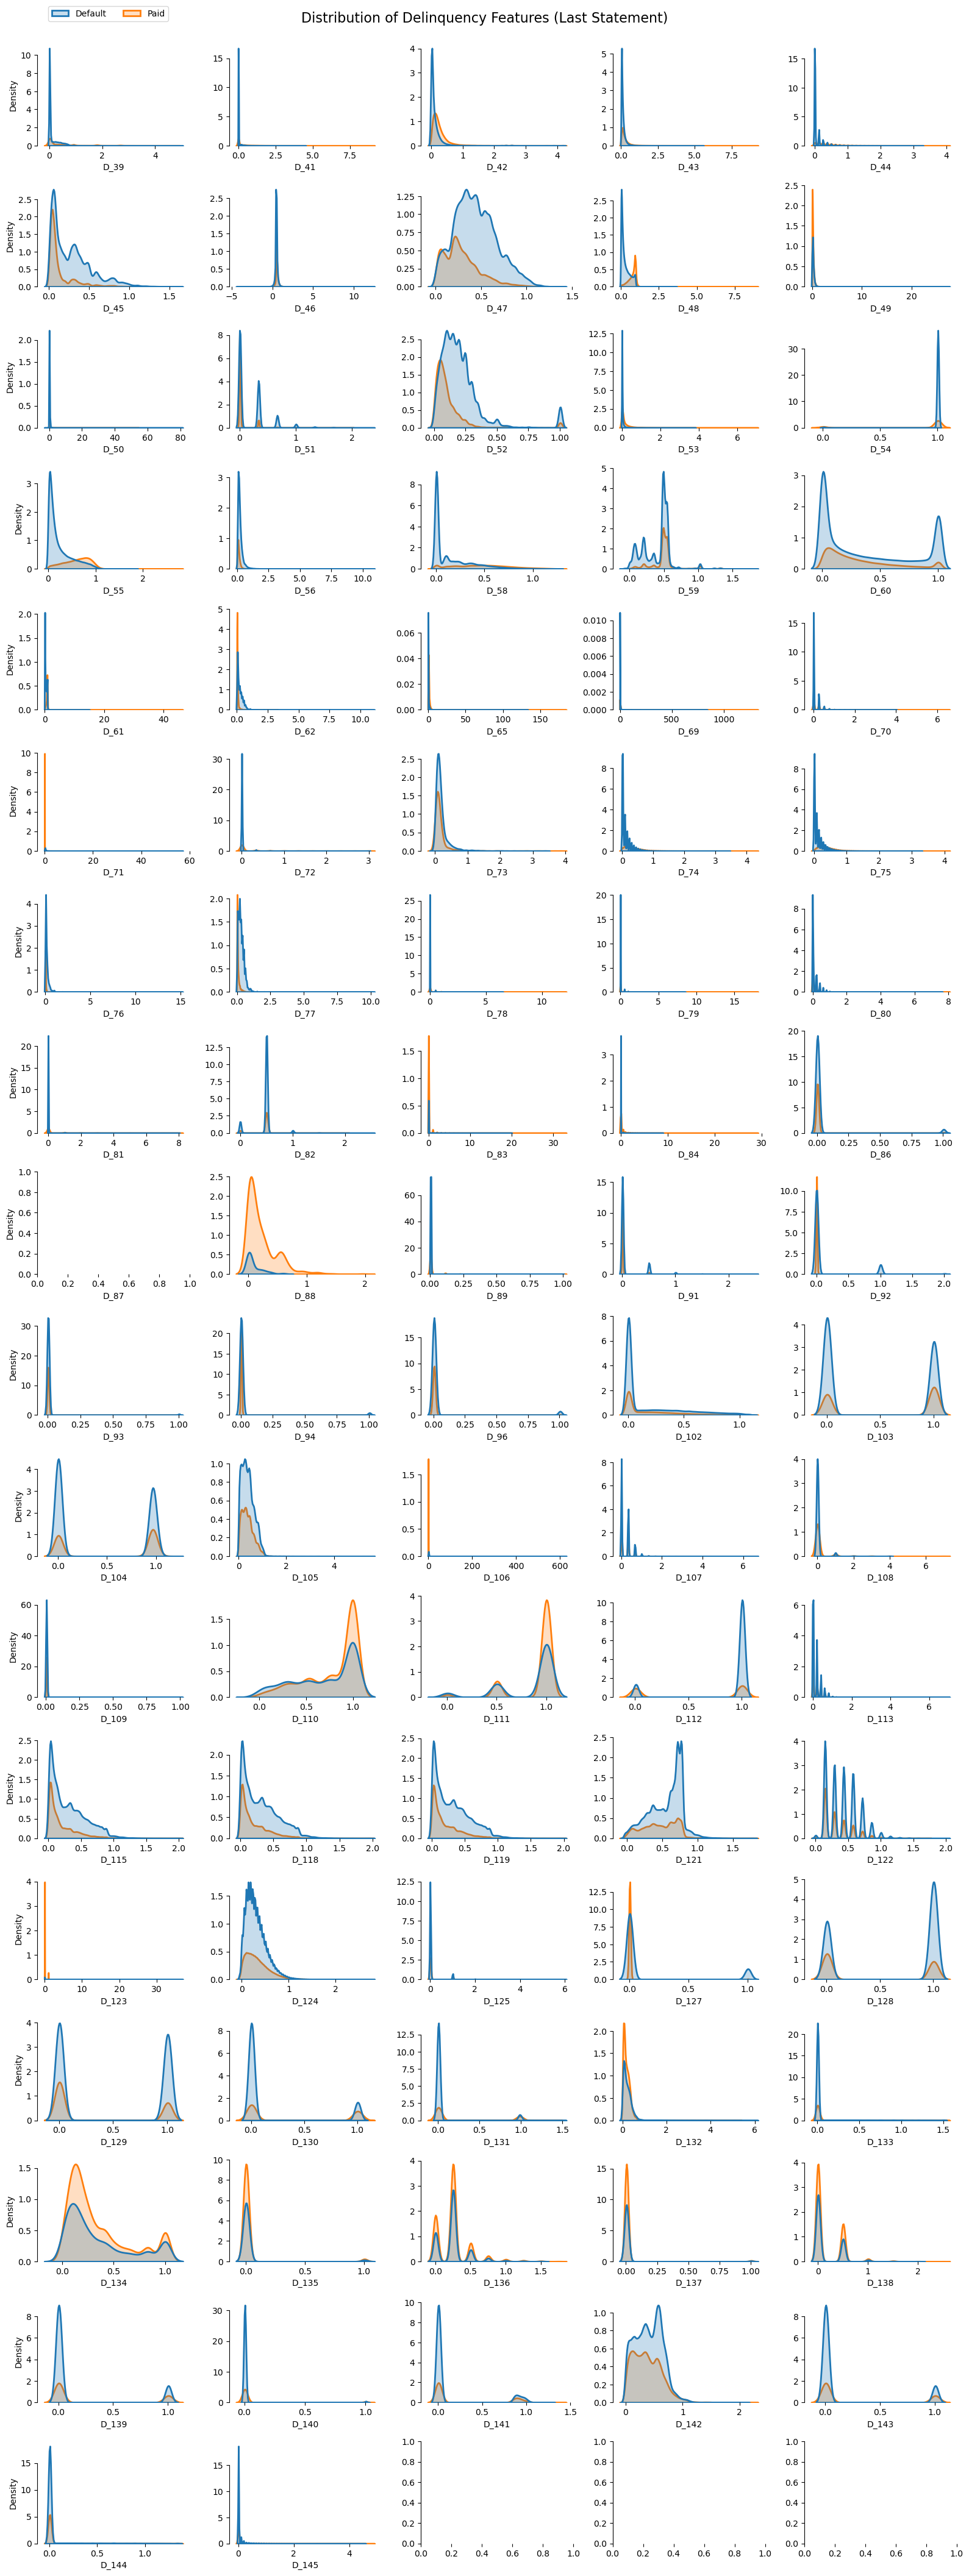

In [29]:
cols=[col for col in last_statement_df.columns if (col.startswith(('D','t'))) & (col not in cat_features)]
plot_kde_last_statement(cols, 'Distribution of Delinquency Features (Last Statement)')

### Key Insights:

- If the two distributions (default vs. paid) are very separate for a  feature, it shows that the feature could have useful information about the target and should be used in predictive modelling. 

- For some of the features such as D_134, D_121, etc., the distribution for bad customers is similar in shape to the distribution of good customers, but the distribution is shifted up or down in the y axis. This may show similar overall behavioral pattern for good and bad customers. The shift in the scale of the distribution could show that the scale of the behavior (such as amout spent) is different for the two groups.

### Correlation Between Delinquency Features

Let's look at the correlation plot for the delinquency features. Correlation heatmaps visualize the relationship between numerical variables. They help understand which features are related to each other and the strength of this relationship.

In [7]:
def plot_corr_heatmap(features, title):
   
    corr=last_statement_df[features].iloc[:,:-1].corr()

    mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
    corr=corr.iloc[1:,:-1].copy()

    fig, ax = plt.subplots(figsize=(48,48))   
    sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', cmap='inferno', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)

    ax.tick_params(left=False,bottom=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

    plt.title(f'{title}\n', fontsize=26)
    fig.show()


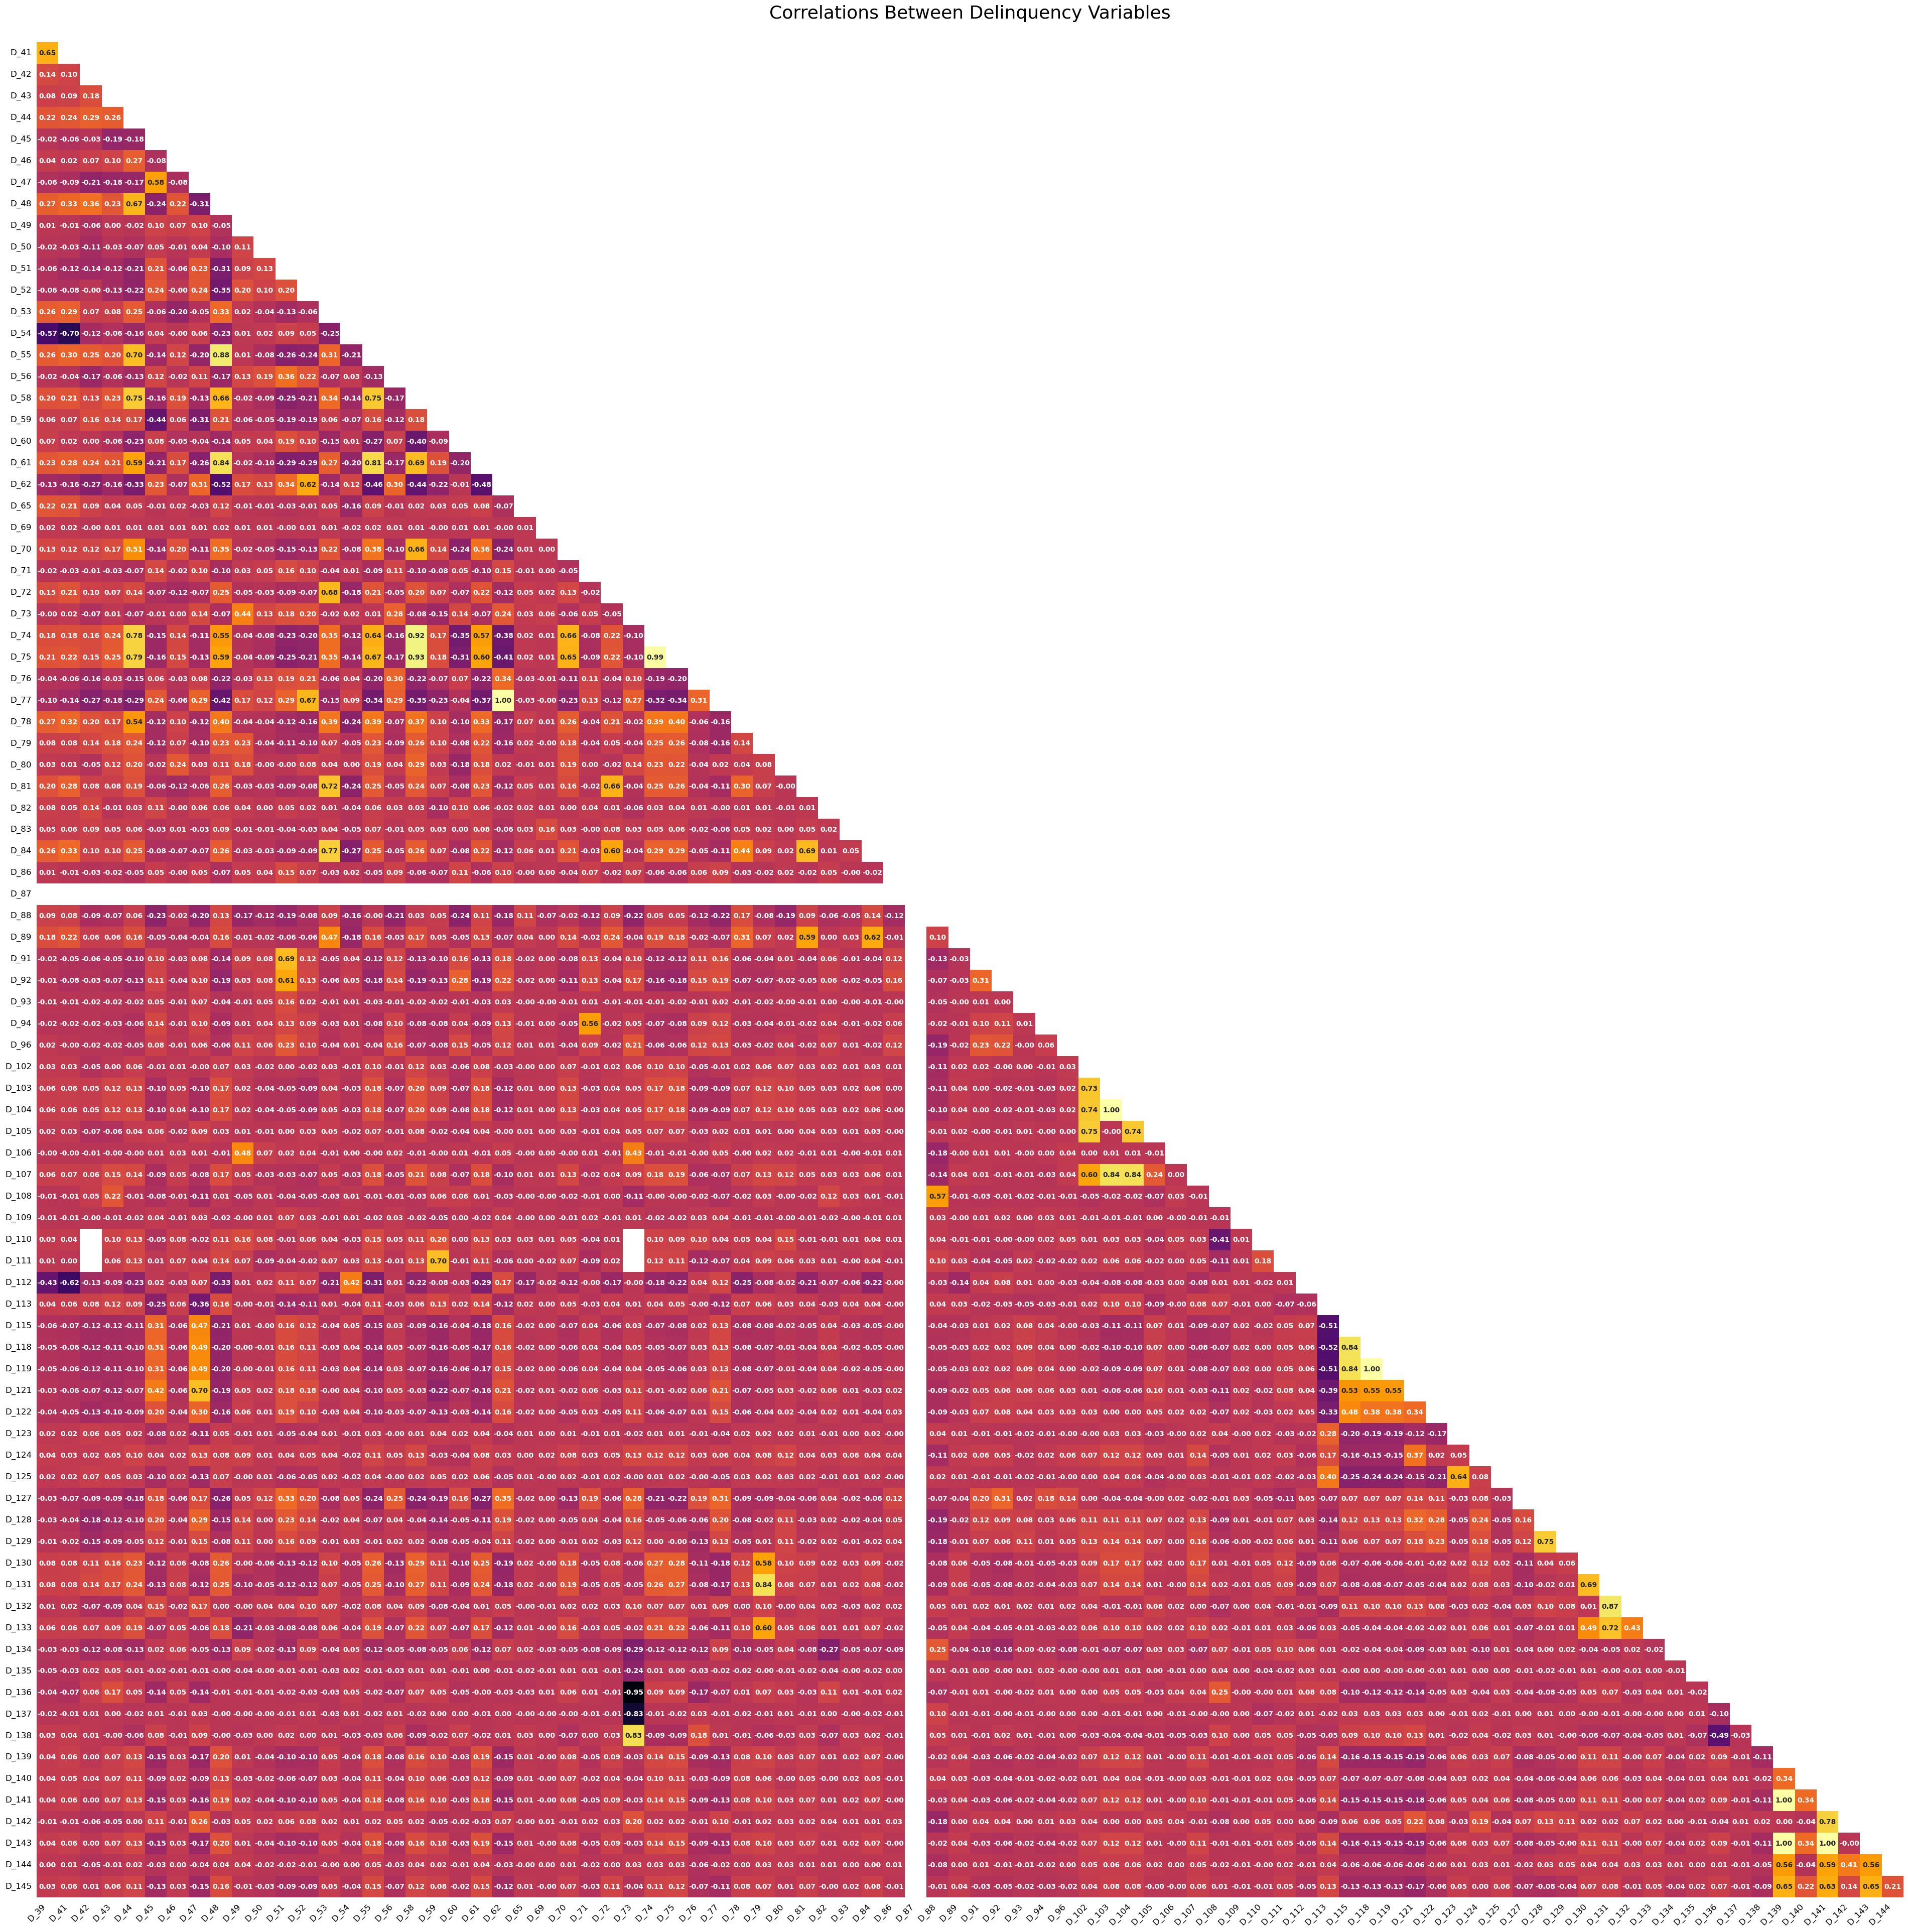

In [14]:
plot_corr_heatmap(cols, 'Correlation Between Delinquency Variables')

Some of the delinquency variables are highly correlated:

In [69]:
cols=[col for col in last_statement_df.columns if (col.startswith(('D','t'))) & (col not in cat_features)]
corr=last_statement_df[cols].iloc[:,:-1].corr()
np.fill_diagonal(corr.values, 0.0)
mask = np.triu(np.ones_like(corr, dtype=bool))
corr = corr.mask(mask)
highly_correlated_features = corr[np.abs(corr) > 0.9].stack().reset_index()
highly_correlated_features=highly_correlated_features.iloc[abs(highly_correlated_features[0]).argsort()[::-1]].reset_index()
highly_correlated_features

index level_0 level_1         0
0      3    D_77    D_62  0.999824
1      4   D_104   D_103  0.999745
2      8   D_143   D_139  0.999602
3      7   D_141   D_139  0.998100
4      9   D_143   D_141  0.997739
5      5   D_119   D_118  0.996339
6      2    D_75    D_74  0.988533
7      6   D_136    D_73 -0.953685
8      1    D_75    D_58  0.927898
9      0    D_74    D_58  0.923637

In [100]:
def plot_highly_correlated_featuers(features, title, highly_correlated_features):
    
    fig, axs = plt.subplots(int(len(highly_correlated_features)/4)+(1 if len(highly_correlated_features)%4!=0 else 0),4, figsize=(16,5*(int(len(highly_correlated_features)/4)+(1 if len(highly_correlated_features)%4!=0 else 0))))
    i=0
    for f,g in zip(highly_correlated_features.level_0, highly_correlated_features.level_1):

        
        ax = axs[int(i/4), i%4] if ((int(len(highly_correlated_features)/4)+(1 if len(highly_correlated_features)%4!=0 else 0))>1) else axs[i%4]
                
        if(i==7):
            ax.plot(last_statement_df[features][f], last_statement_df[features][g], '.')
            ax.set(xlabel=f,ylabel=g)
            ax.text(0.05, 0.9, 'Correlation: {:.4f}'.format(highly_correlated_features[0][i]), transform=ax.transAxes, bbox=dict(boxstyle="round,pad=0.3",fc="white"))
            ax.tick_params(left=False,bottom=False)

            i = i + 1
            continue
        


        ax.hexbin(x=f, y=g, data=last_statement_df[features], bins='log', gridsize=40, cmap='inferno')
        ax.set(xlabel=f,ylabel=g)

        ax.text(0.05, 0.9, 'Correlation: {:.4f}'.format(highly_correlated_features[0][i]), transform=ax.transAxes, bbox=dict(boxstyle="round,pad=0.3",fc="white"))
        ax.tick_params(left=False,bottom=False)
        i = i + 1

    sns.despine()
    fig.suptitle(f'\n{title})',fontsize=14)
    plt.show()

In [5]:
def plot_highly_correlated_featuers(features, title, highly_correlated_features):
    
    fig, axs = plt.subplots(int(len(highly_correlated_features)/4)+(1 if len(highly_correlated_features)%4!=0 else 0),4, figsize=(16,5*(int(len(highly_correlated_features)/4)+(1 if len(highly_correlated_features)%4!=0 else 0))))
    i=0
    for f,g in zip(highly_correlated_features.level_0, highly_correlated_features.level_1):

        
        ax = axs[int(i/4), i%4] if ((int(len(highly_correlated_features)/4)+(1 if len(highly_correlated_features)%4!=0 else 0))>1) else axs[i%4]
        


        ax.hexbin(x=f, y=g, data=last_statement_df[features], bins='log', gridsize=40, cmap='inferno')
        ax.set(xlabel=f,ylabel=g)

        ax.text(0.05, 0.9, 'Correlation: {:.4f}'.format(highly_correlated_features[0][i]), transform=ax.transAxes, bbox=dict(boxstyle="round,pad=0.3",fc="white"))
        ax.tick_params(left=False,bottom=False)
        i = i + 1

    sns.despine()
    fig.suptitle(f'\n{title})',fontsize=14)
    plt.show()

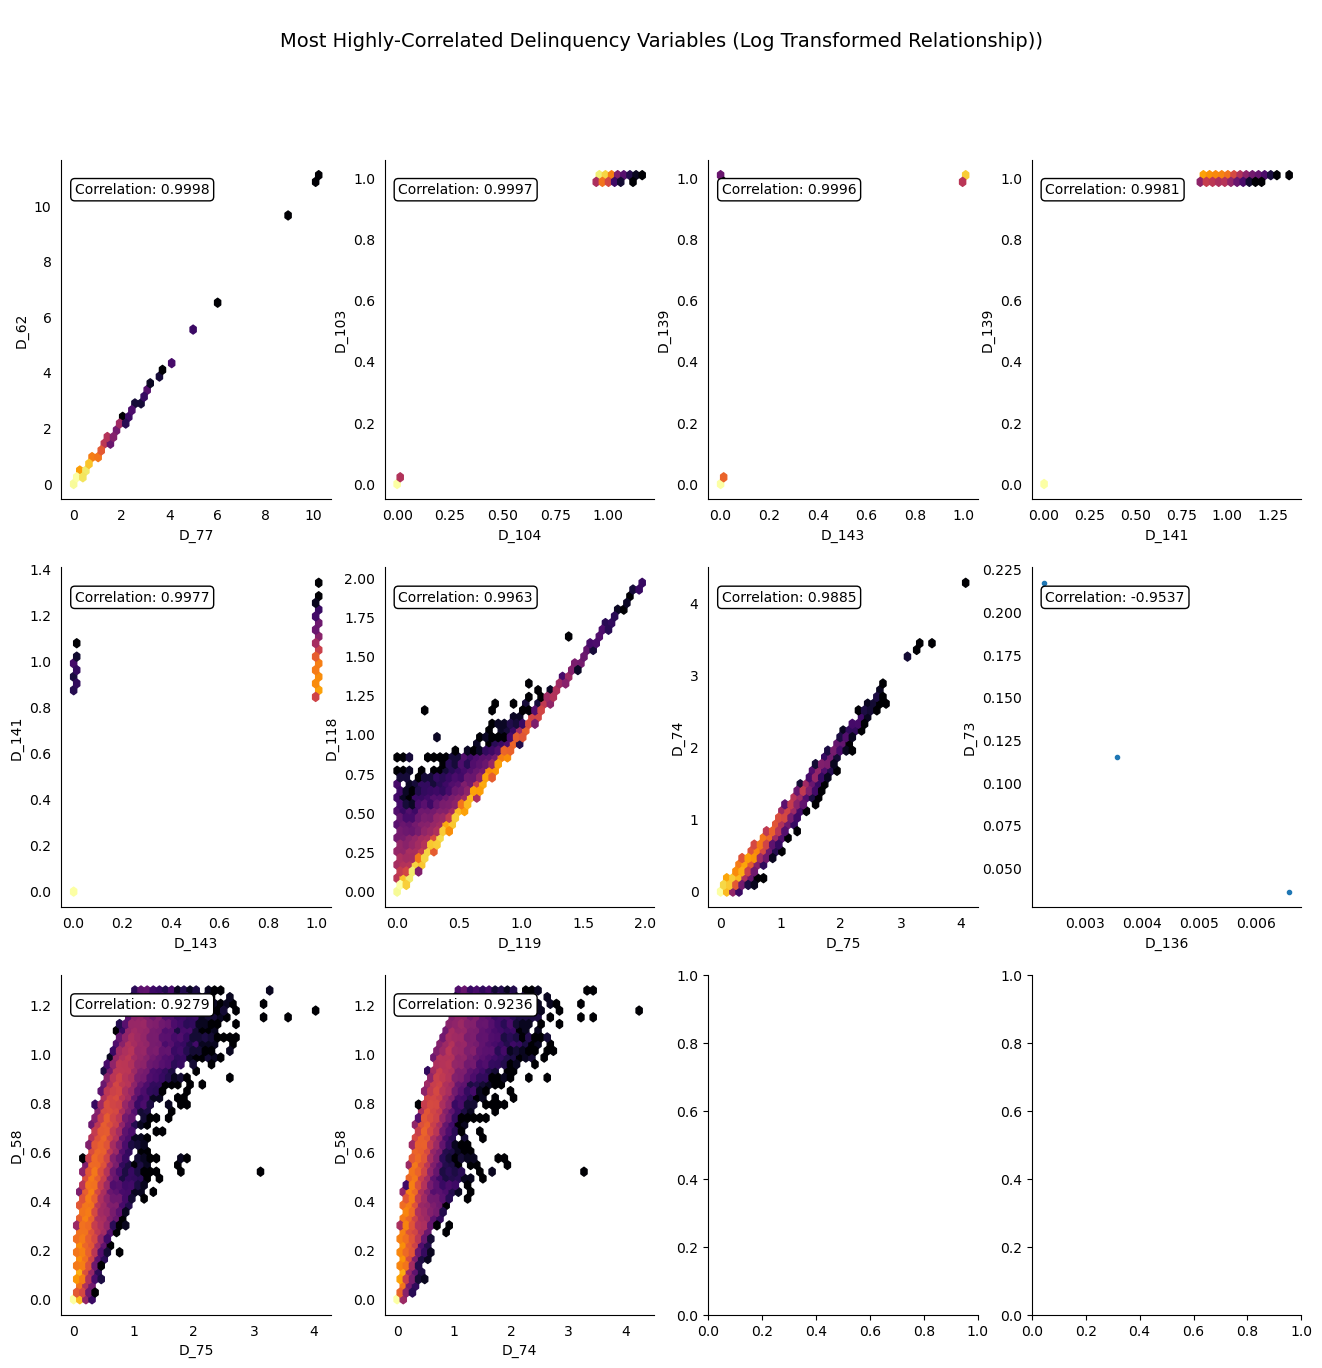

In [101]:
plot_highly_correlated_featuers(cols, 'Most Highly-Correlated Delinquency Variables (Log Transformed Relationship)', highly_correlated_features)

Key Insights: 

- Τhere are several highly correlated Delinquency variables, with the highest correlation being 0.999824, between D_77 and D_62.

- There is some missing correlations in the correlation heatmap. This is due to null values in the data.

### 5.5.2. Spend Variables

There are 21 Spend variables, all of which are numerical features. Let's look at histograms, KDE plots and correlation heatmaps for the spend features.

In [25]:
spend_features = sorted([f for f in train_data.columns if (f not in ['customer_ID', 'target', 'S_2']) and (f.startswith(('S')))])

In [28]:
print(f"Number of spend features: {len(spend_features)}")
print(f"Number of numerical spend features: {len([f for f in spend_features if f not in cat_features])}")

Number of spend features: 21
Number of numerical spend features: 21


There are no categorical spend features.

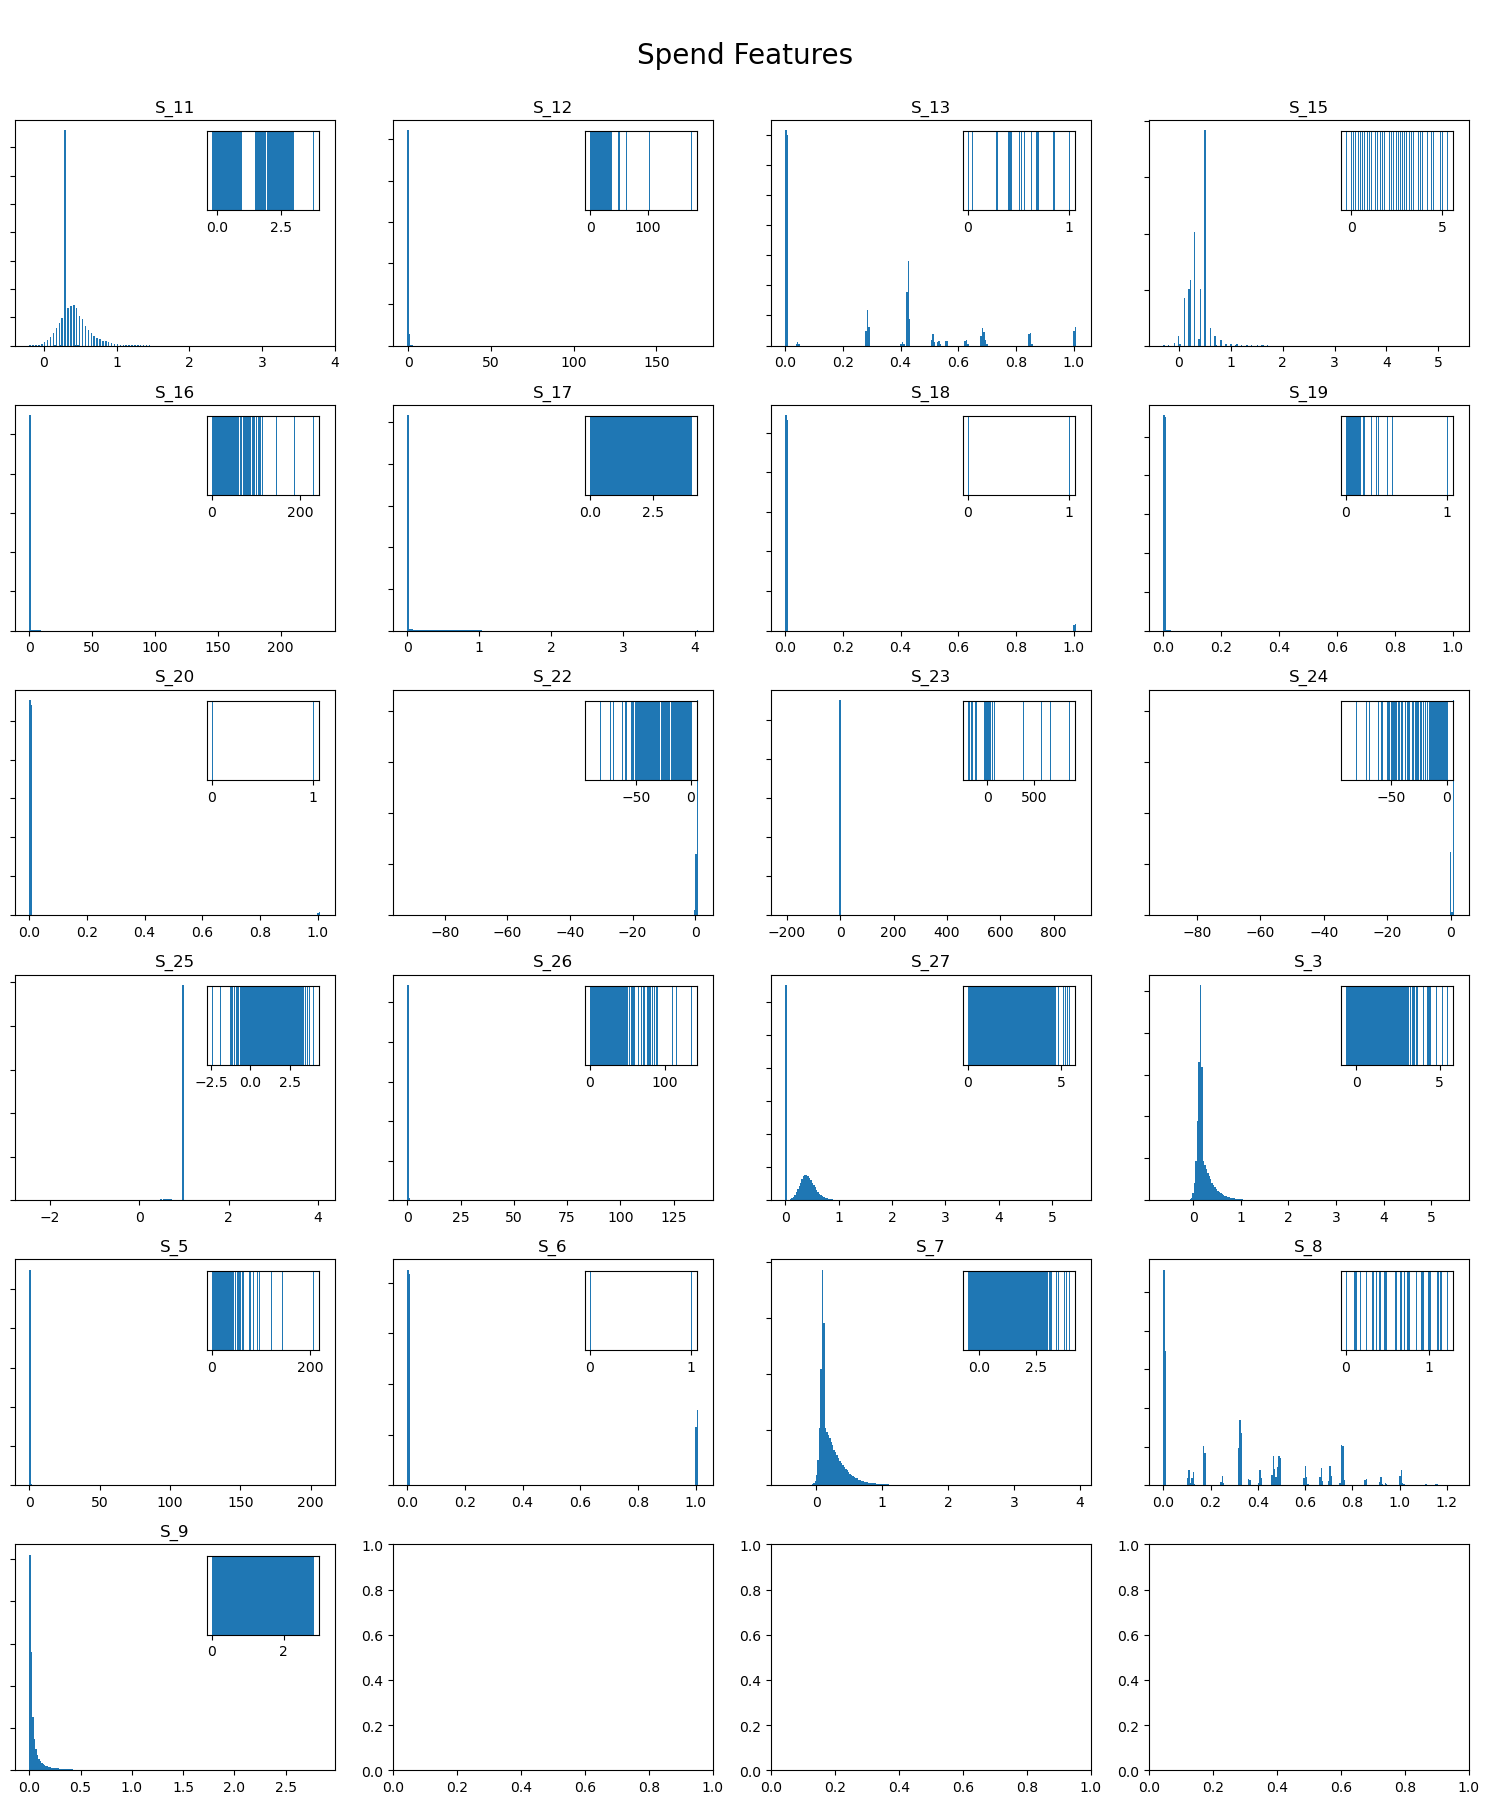

In [10]:
plot_hist(spend_features, 'Spend Features')

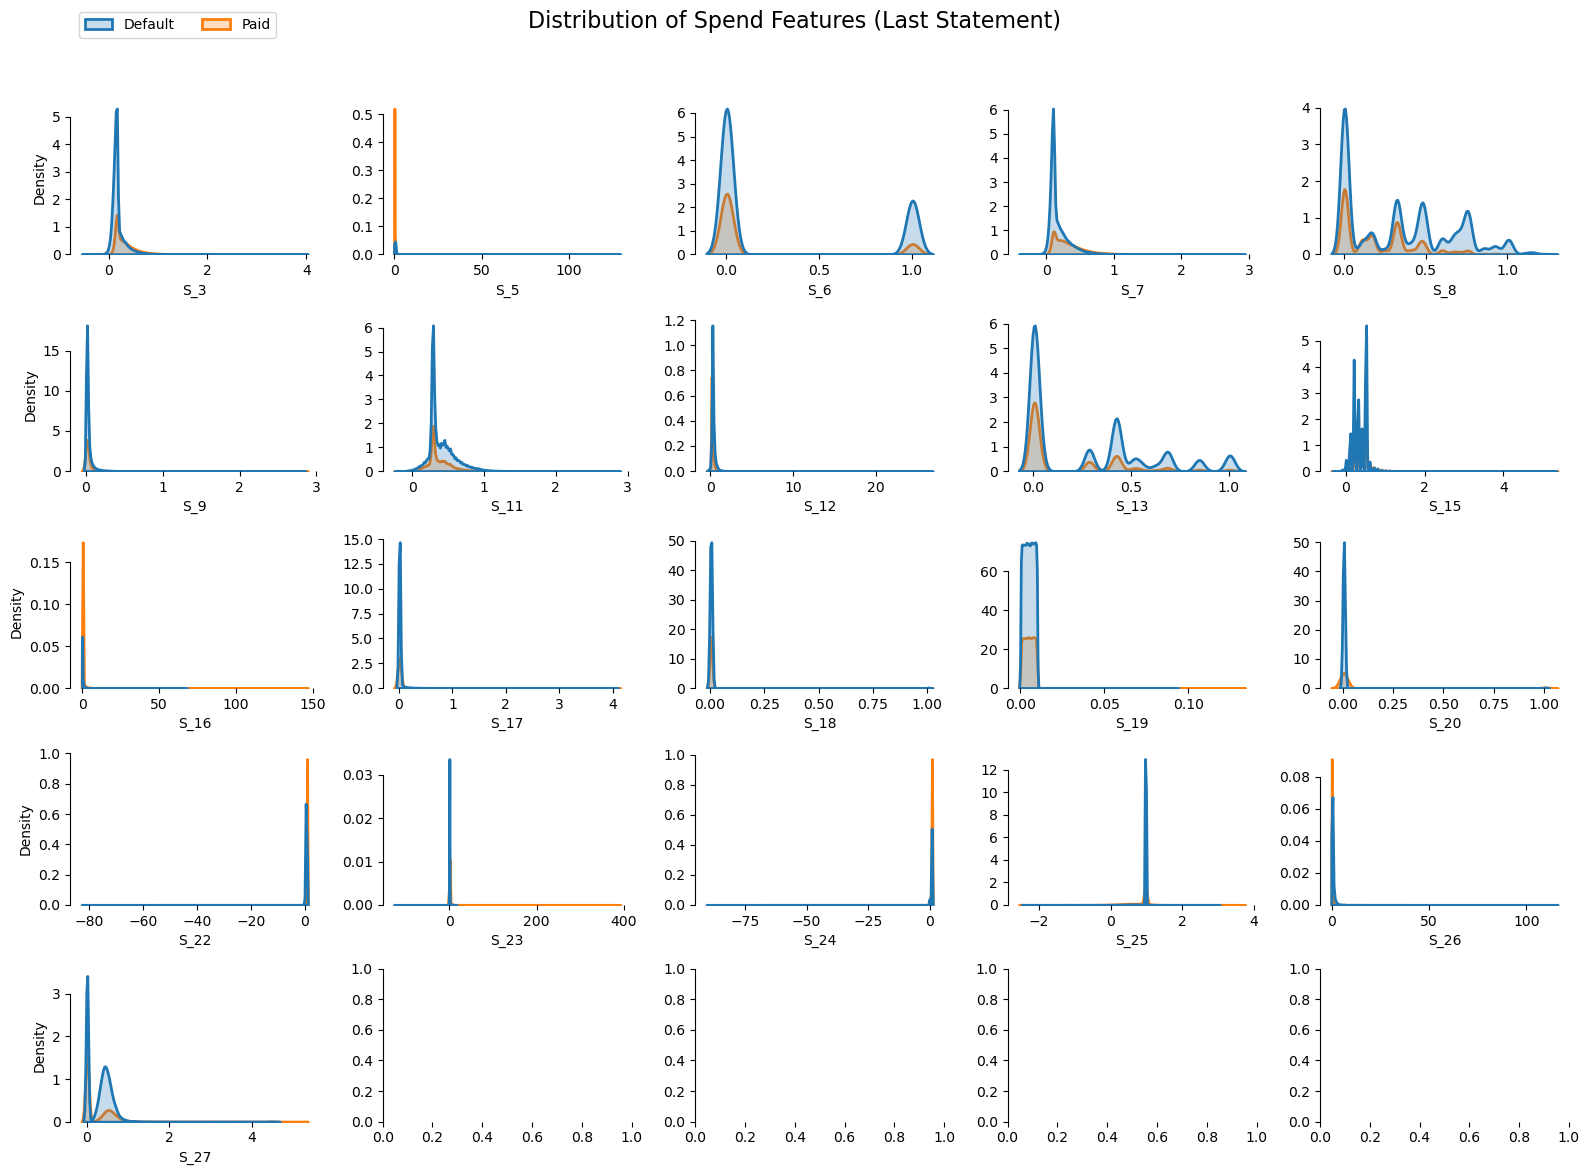

In [13]:
cols=[col for col in last_statement_df.columns if (col.startswith(('S','t'))) & (col not in cat_features+['S_2'])]
plot_kde_last_statement(cols, 'Distribution of Spend Features (Last Statement)')

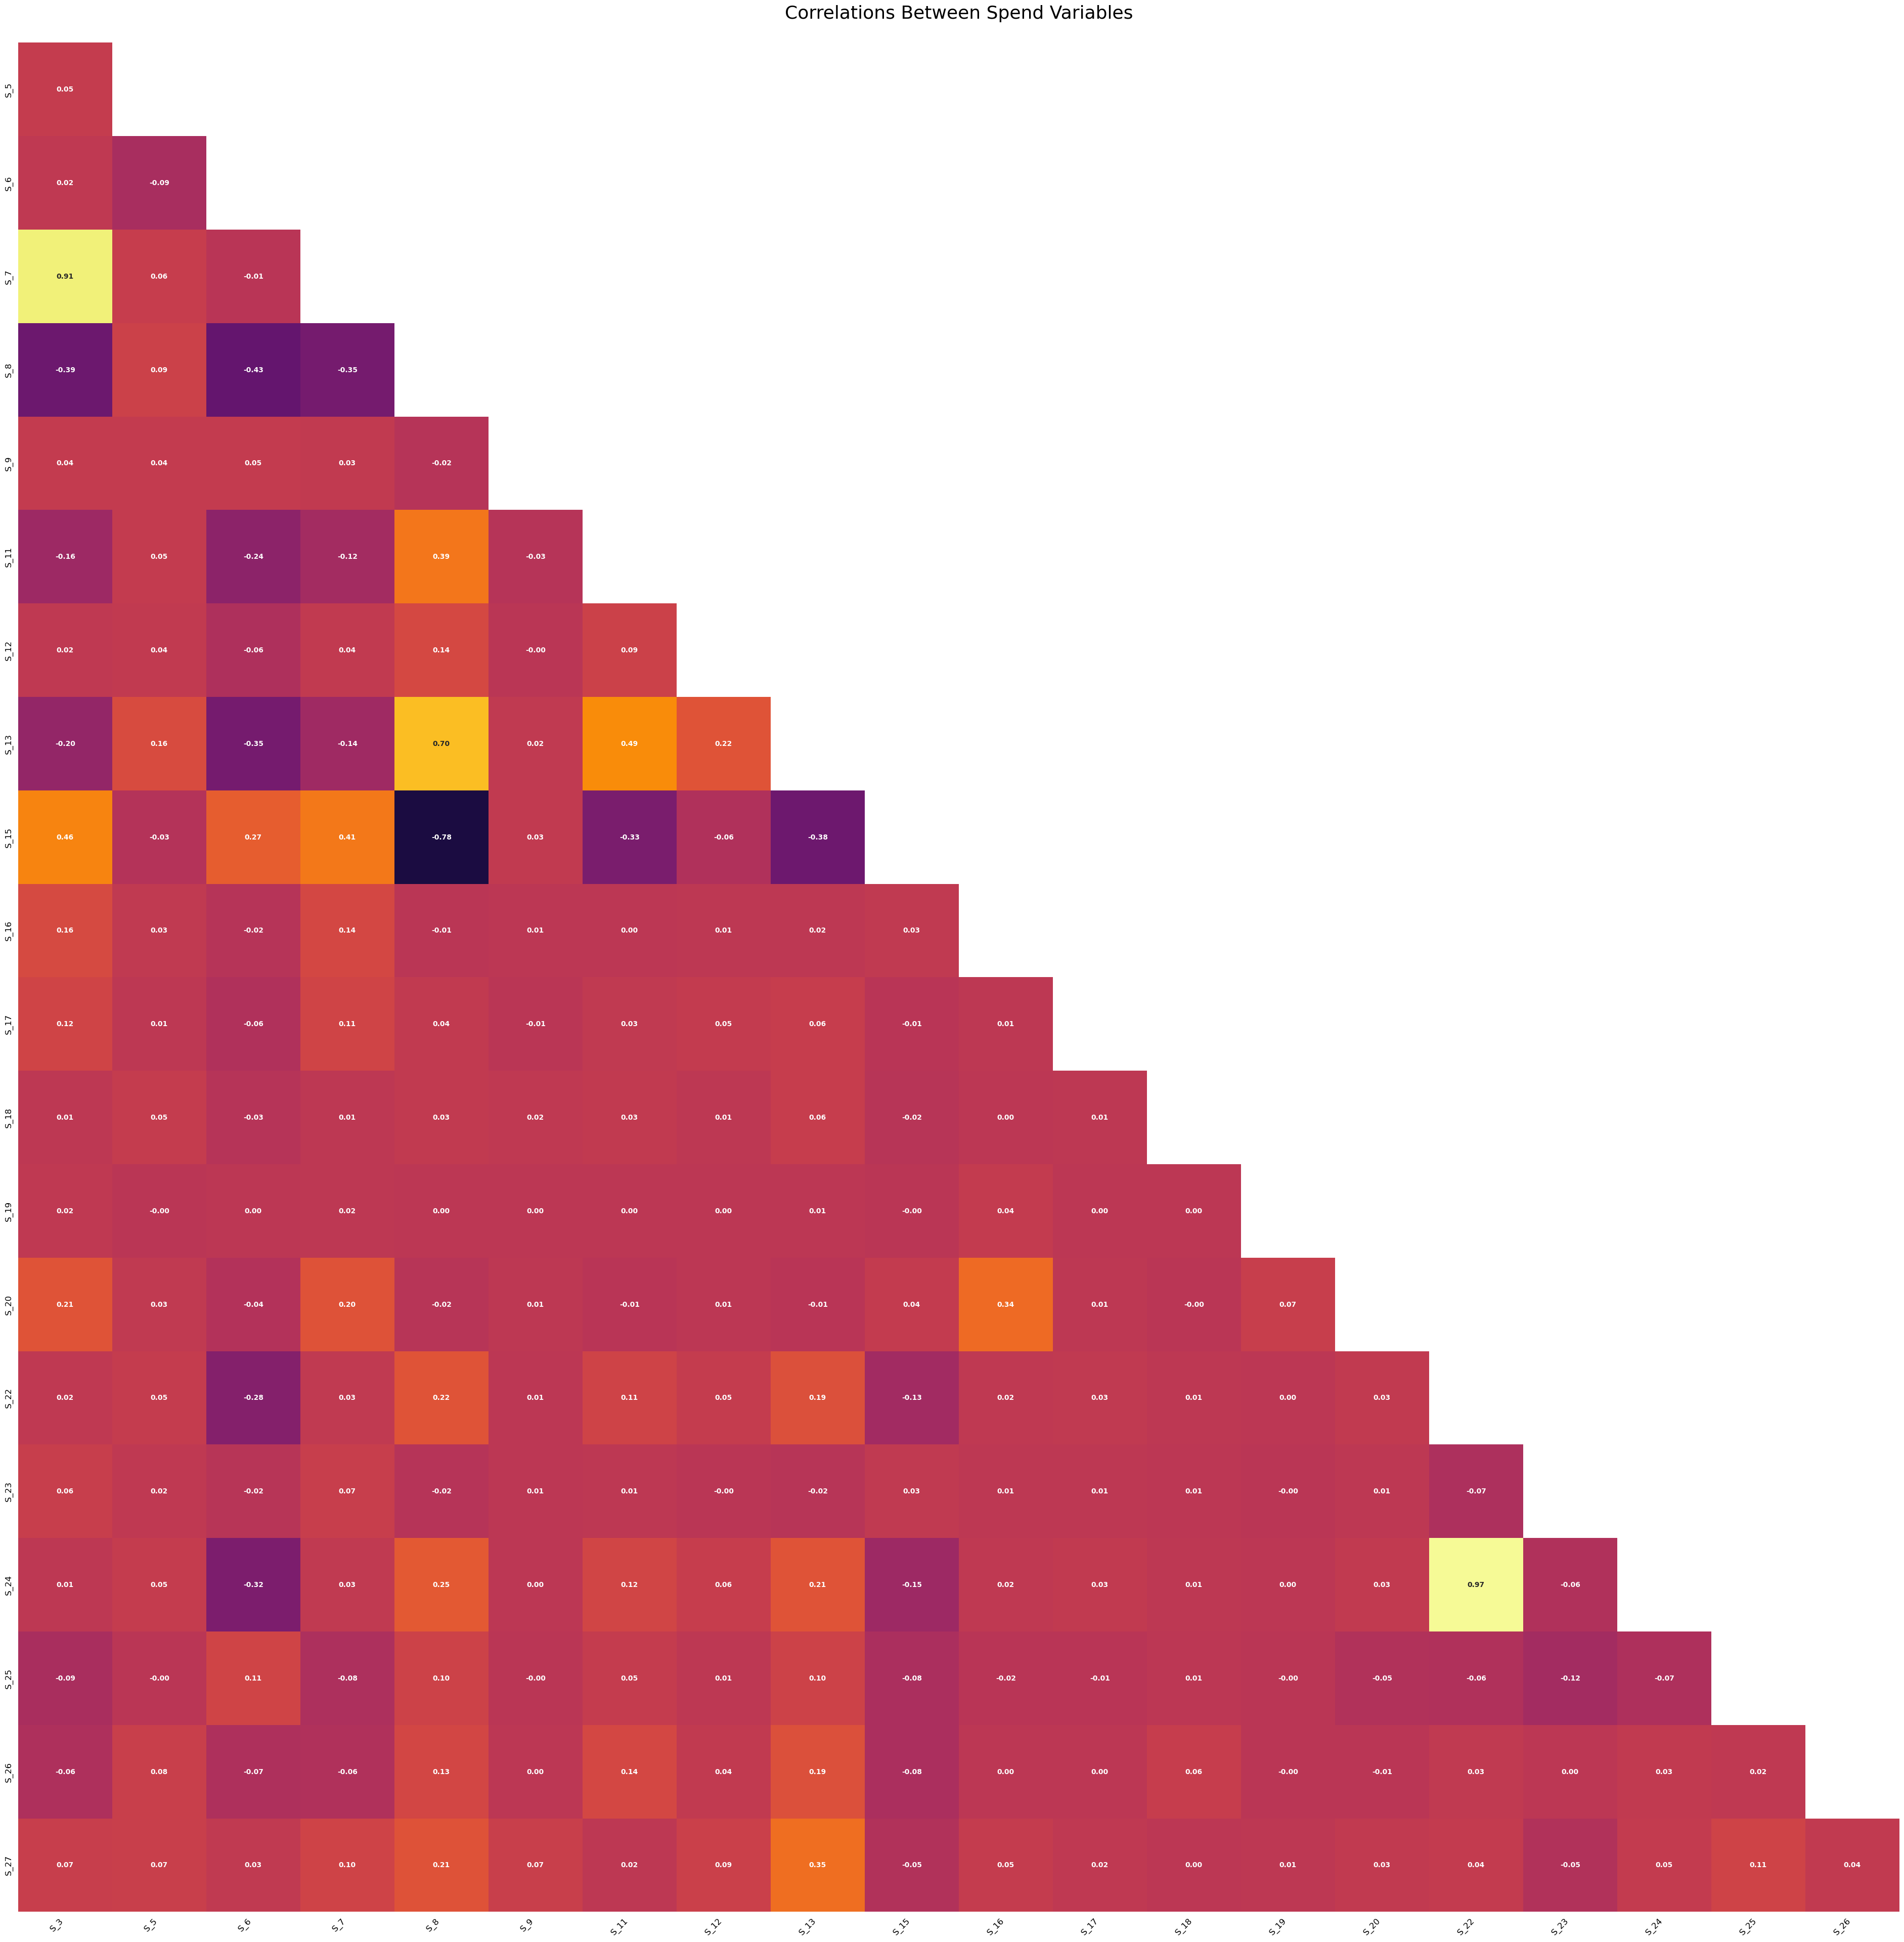

In [33]:
plot_corr_heatmap(cols, 'Correlations Between Spend Variables')

In [18]:
corr=last_statement_df[cols].iloc[:,:-1].corr()
np.fill_diagonal(corr.values, 0.0)
mask = np.triu(np.ones_like(corr, dtype=bool))
corr = corr.mask(mask)
highly_correlated_features = corr[np.abs(corr) > 0.9].stack().reset_index()
highly_correlated_features=highly_correlated_features.iloc[abs(highly_correlated_features[0]).argsort()[::-1]].reset_index()
highly_correlated_features

index level_0 level_1         0
0      1    S_24    S_22  0.965077
1      0     S_7     S_3  0.909011

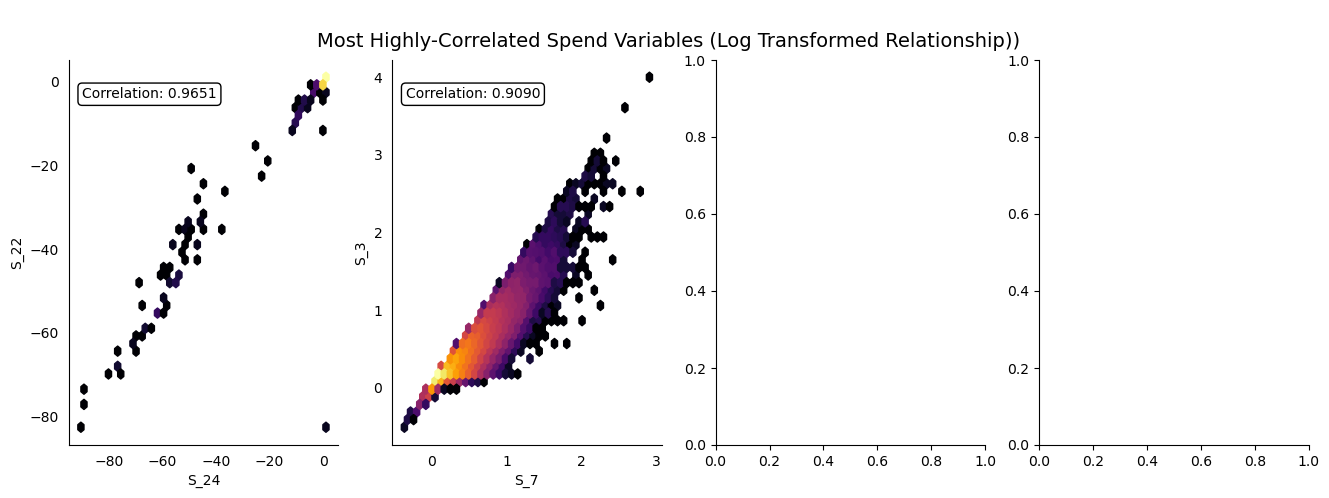

In [19]:
plot_highly_correlated_featuers(cols, 'Most Highly-Correlated Spend Variables (Log Transformed Relationship)', highly_correlated_features)

### Key Insights:

- From the KDE plots, the distributions for target=0 and target=1 differ. The spend variables seem informative about the target and should be included in modelling.

- Some of the spend features are highly correlated to eachother, with correlation between S_22 and S_24 being the highest at 0.965. Keep in mind that this is the Pearson's correlation coefficien. It only measures  linear relationships. Nonlinear relationships might not be well-represented by this coefficient.


### 5.5.3. Payment Variables

In [24]:
payment_features = sorted([f for f in train_data.columns if (f not in ['customer_ID', 'target', 'S_2']) and (f.startswith(('P')))])
print(f"Number of payment features: {len(payment_features)}")
print(f"Number of numerical payment features: {len([f for f in payment_features if f not in cat_features])}")

Number of payment features: 3
Number of numerical payment features: 3


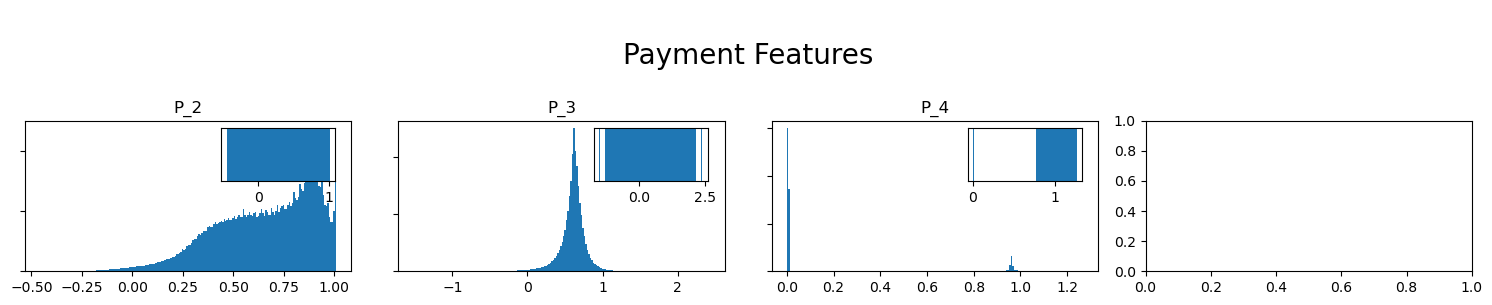

In [85]:
plot_hist(payment_features, 'Payment Features')

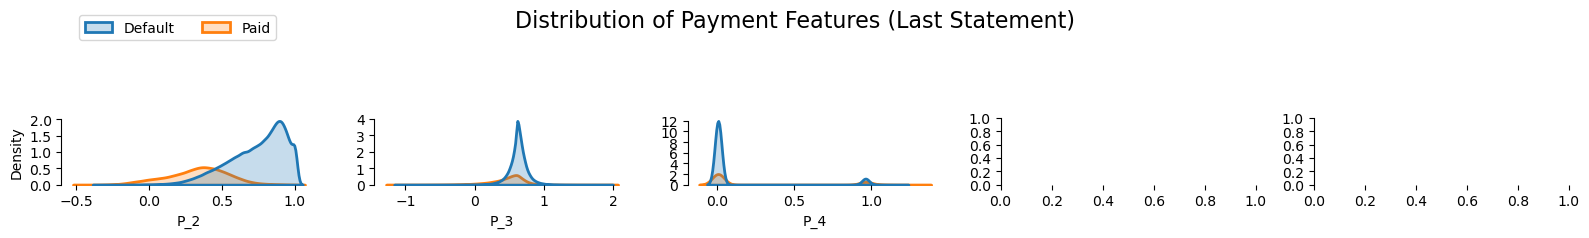

In [17]:
cols=[col for col in last_statement_df.columns if (col.startswith(('P','t'))) & (col not in cat_features)]
plot_kde_last_statement(cols, 'Distribution of Payment Features (Last Statement)')

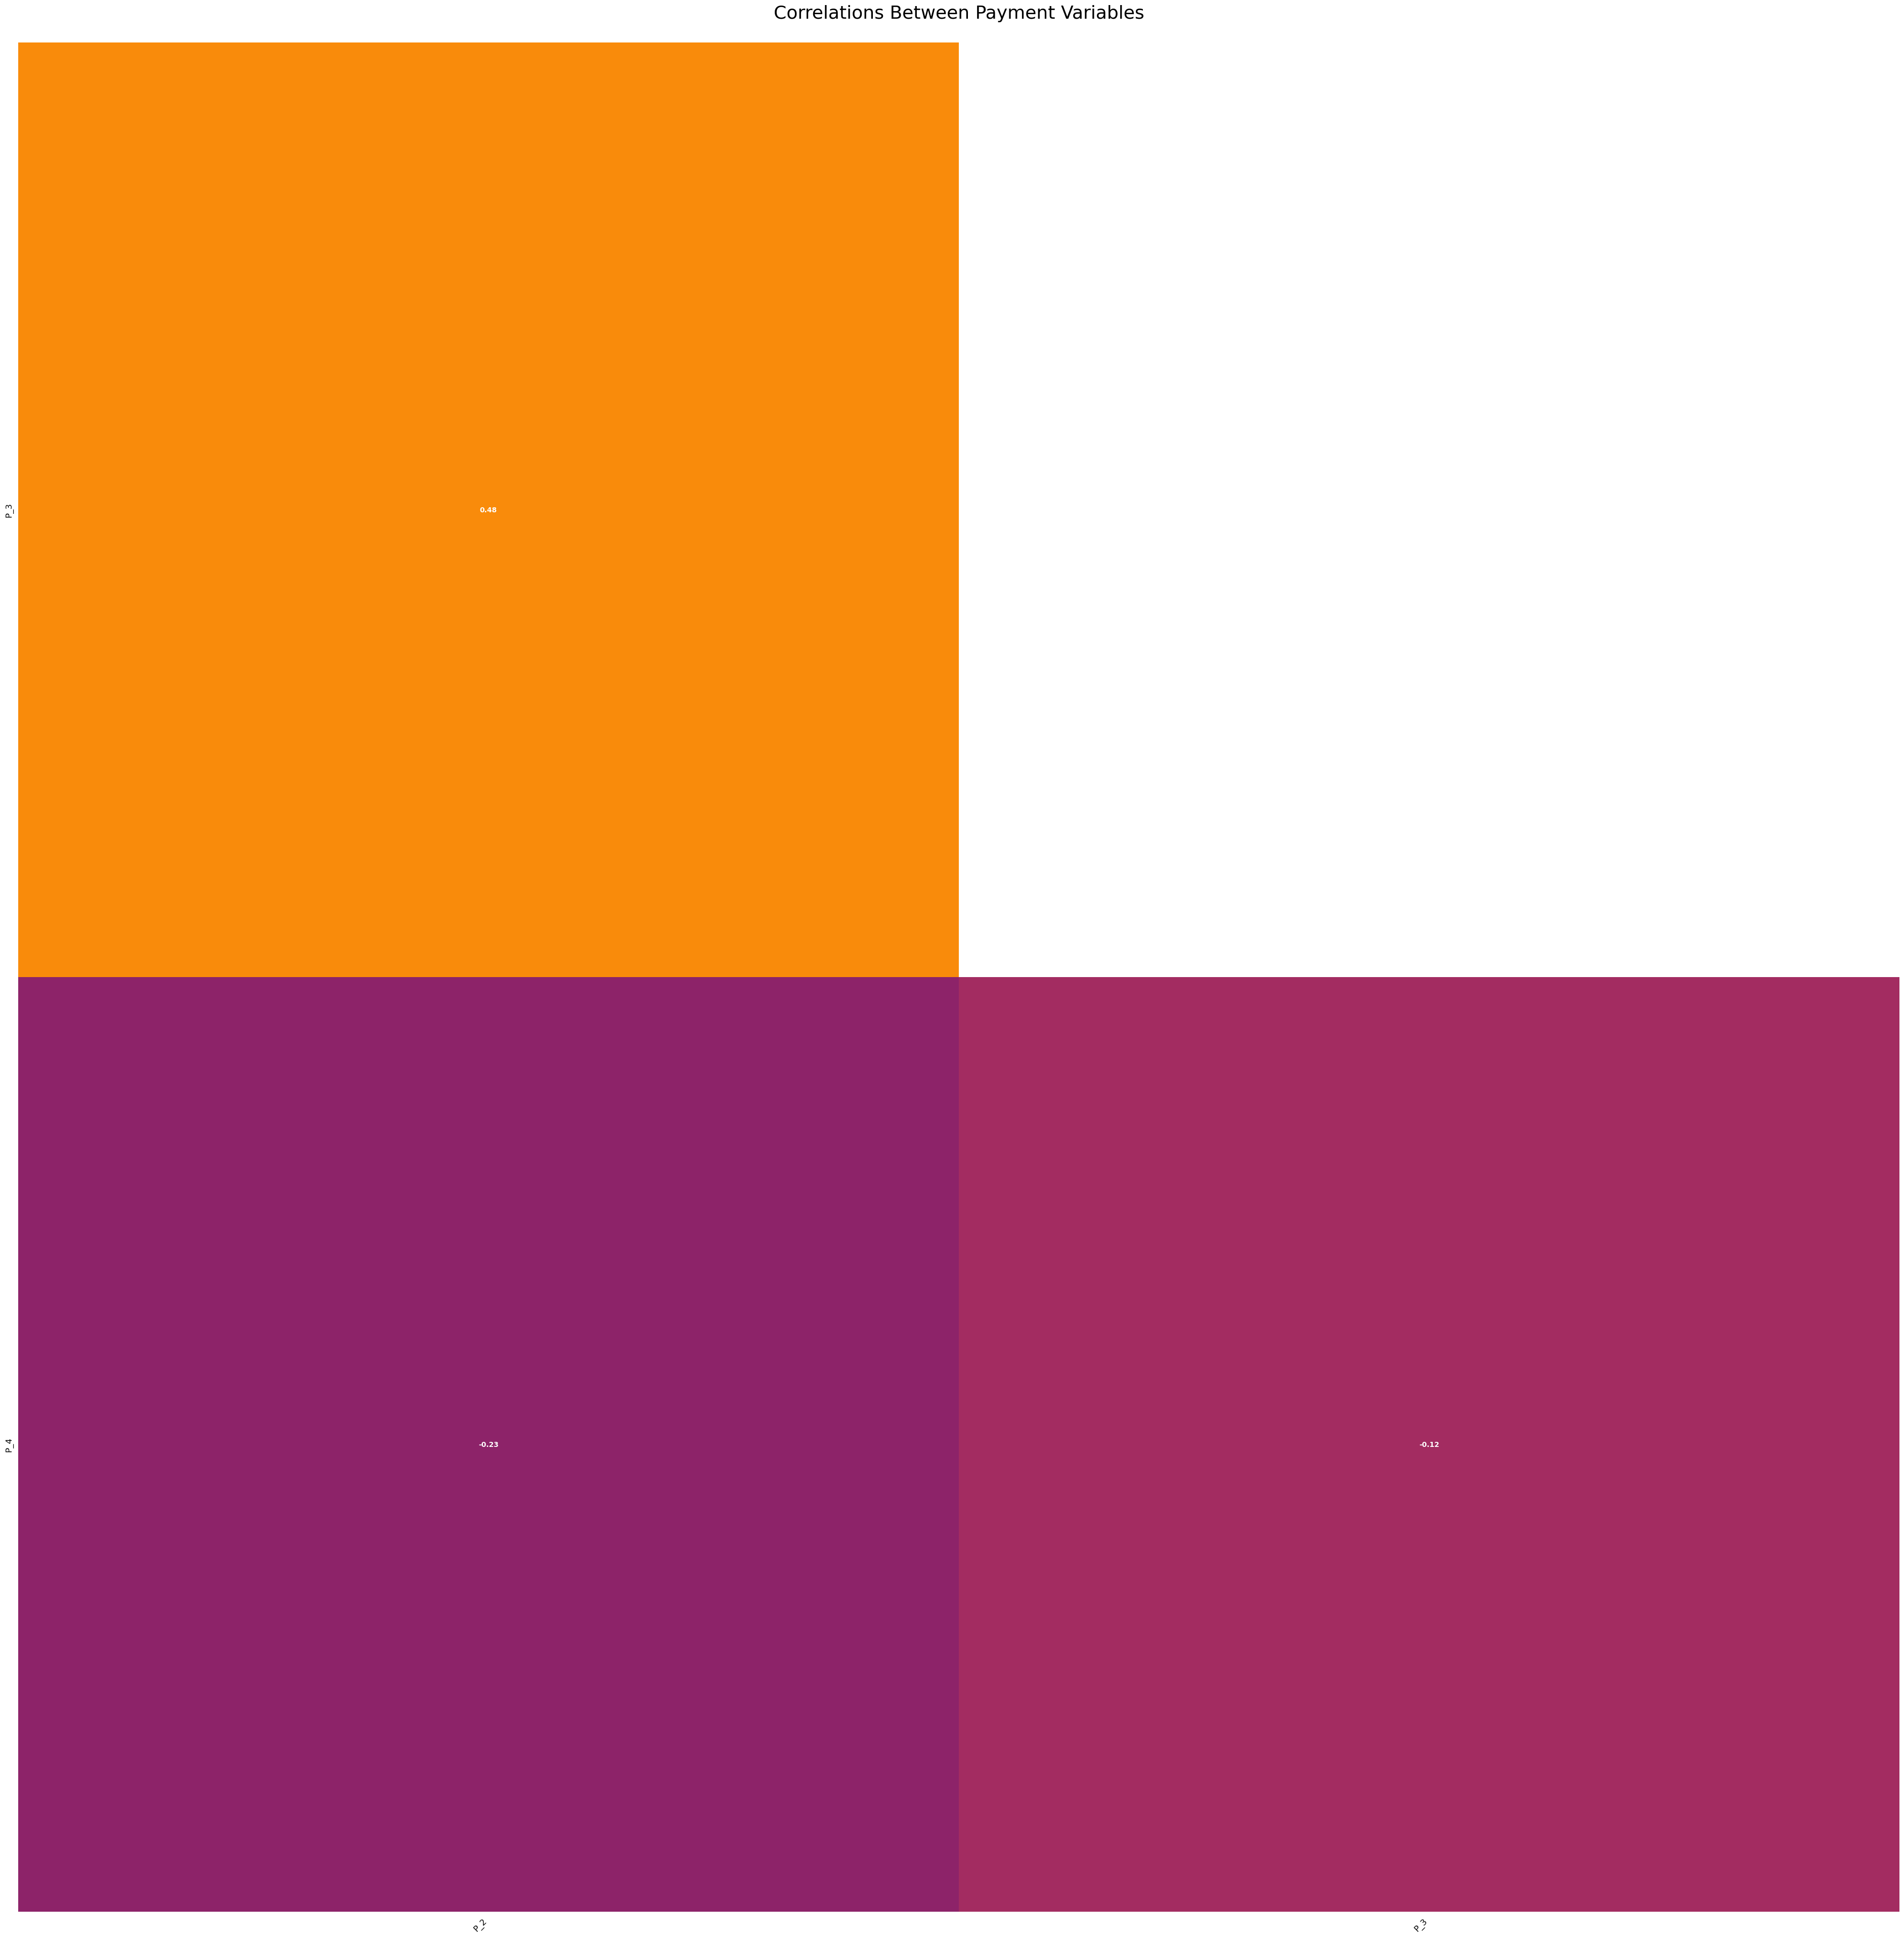

In [87]:
plot_corr_heatmap(cols, 'Correlations Between Payment Variables')

In [60]:
corr=last_statement_df[cols].iloc[:,:-1].corr()
corr.values

array([[ 1.        ,  0.48489685, -0.23340087],
       [ 0.48489685,  1.        , -0.12424216],
       [-0.23340087, -0.12424216,  1.        ]])

Spend Variables are not as highly correlated to each other.

### Key Insights:

- There are only three payment variables. They are not highly correlated to each other.

- Fro mthe KDE plot, P_2 seems to be the most informative about the target.

### 5.5.4. Balance Variables

In [30]:
balance_features = sorted([f for f in train_data.columns if (f not in  ['customer_ID', 'target', 'S_2']) and (f.startswith(('B')))])
print(f"Number of balance features: {len(balance_features)}")
print(f"Number of numerical balance features: {len([f for f in balance_features if f not in cat_features])}")

Number of balance features: 40
Number of numerical balance features: 38


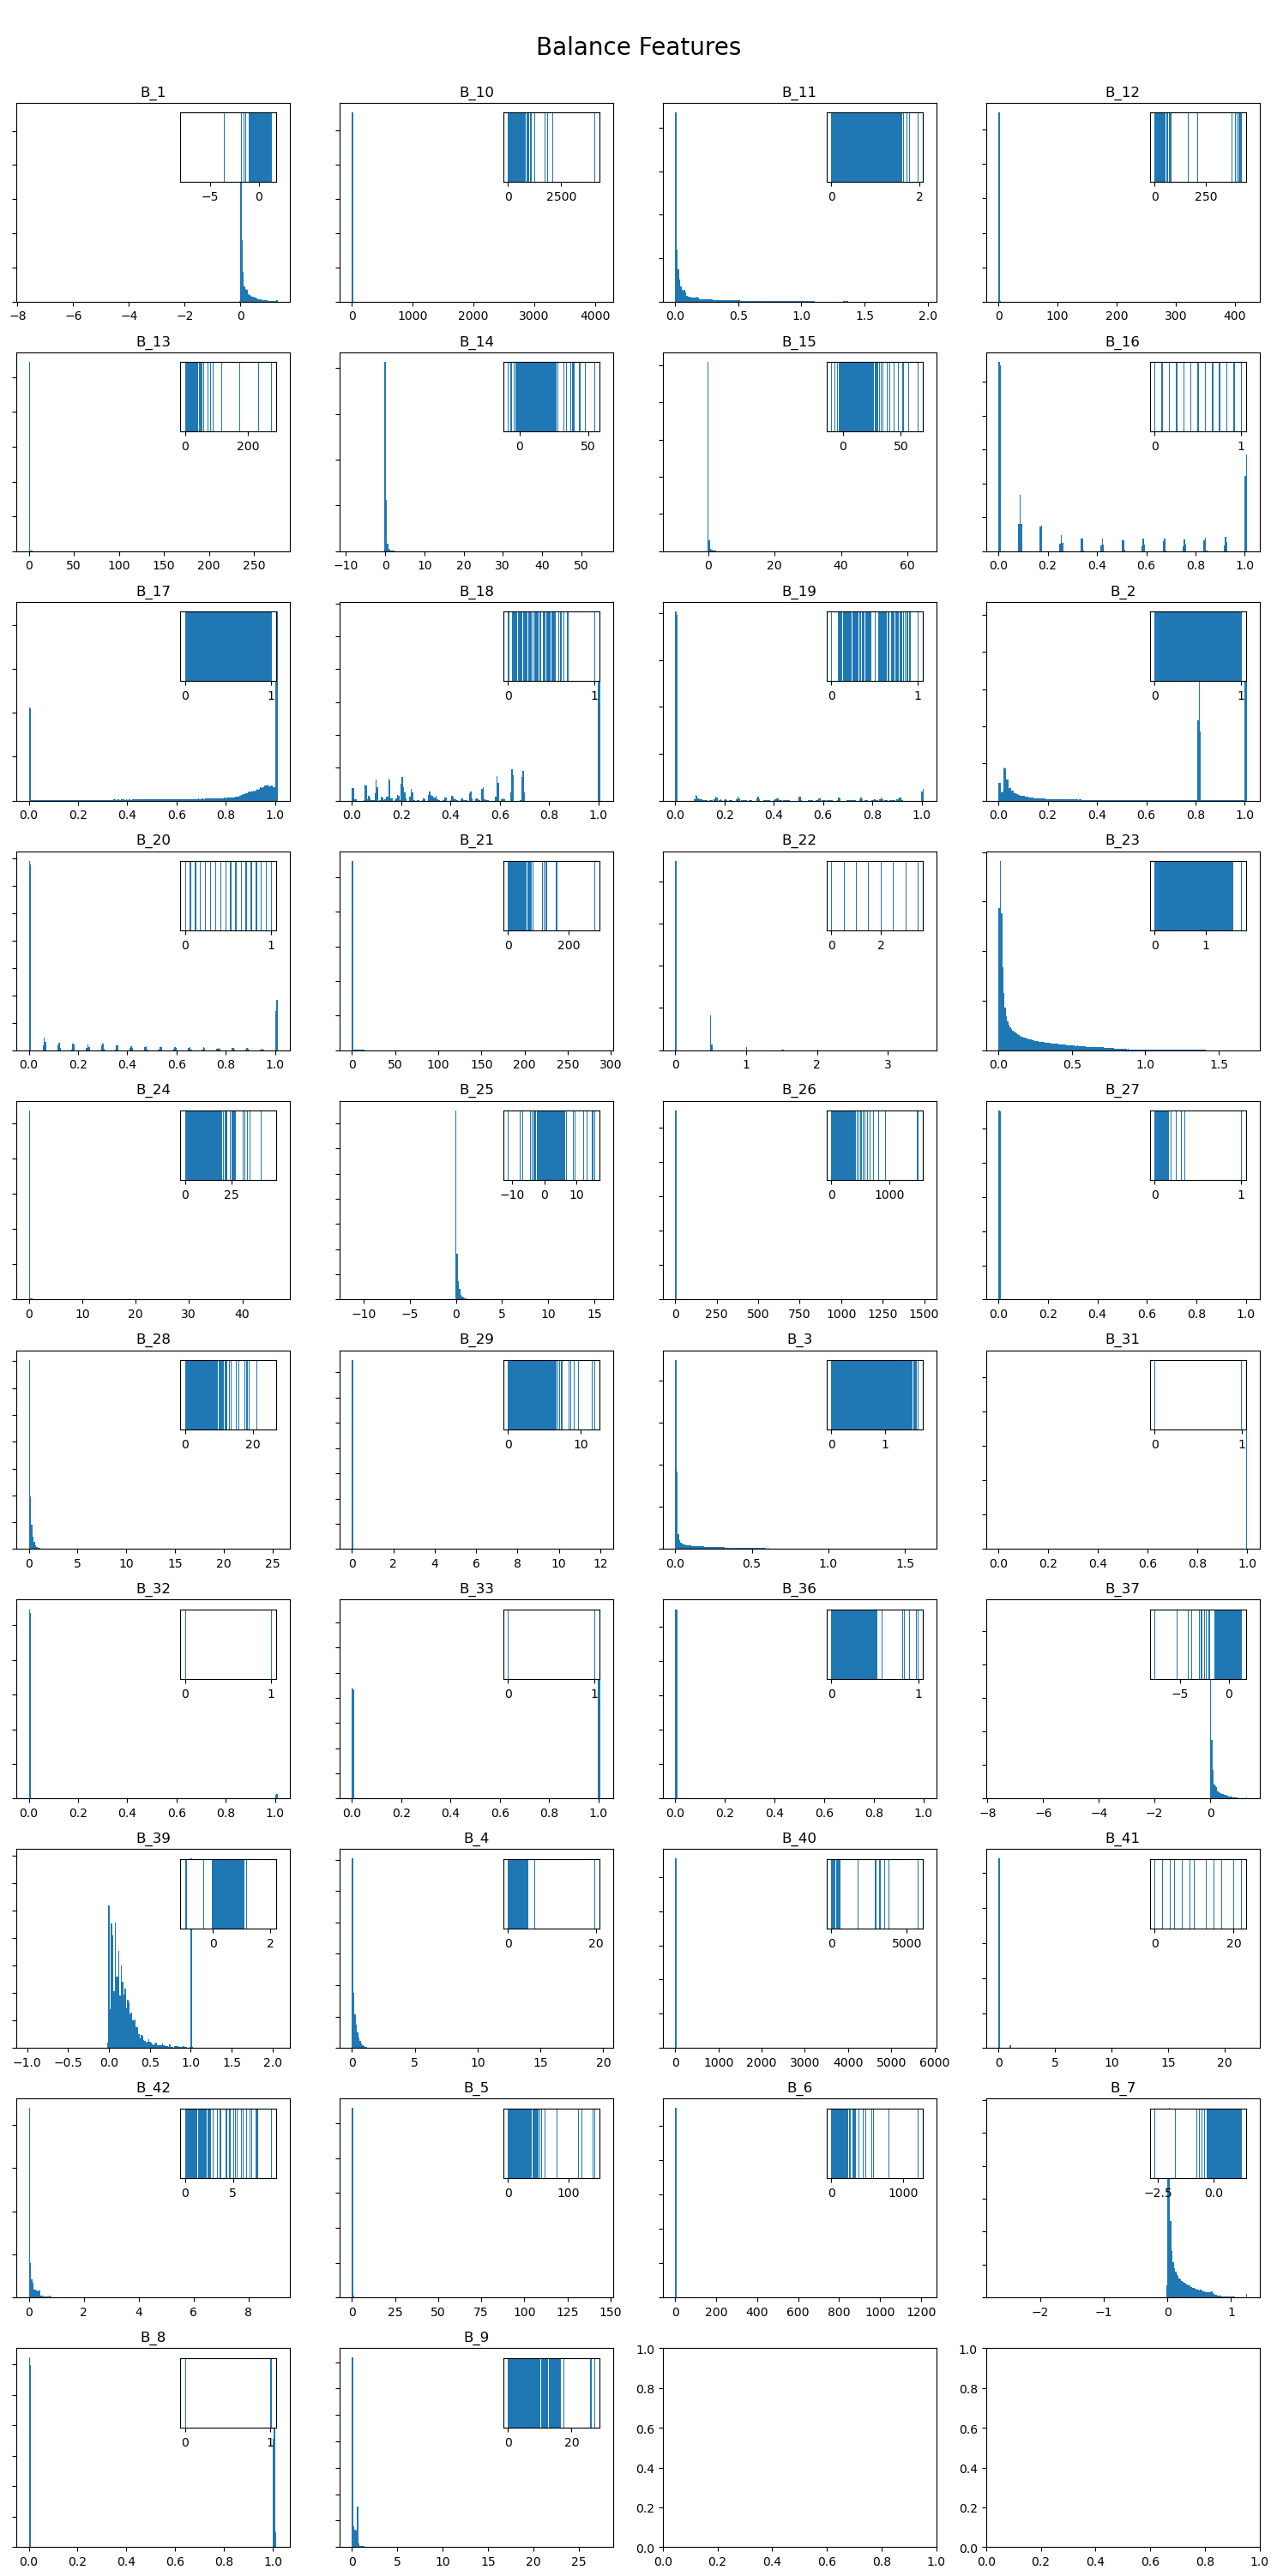

In [62]:
plot_hist(balance_features, 'Balance Features')

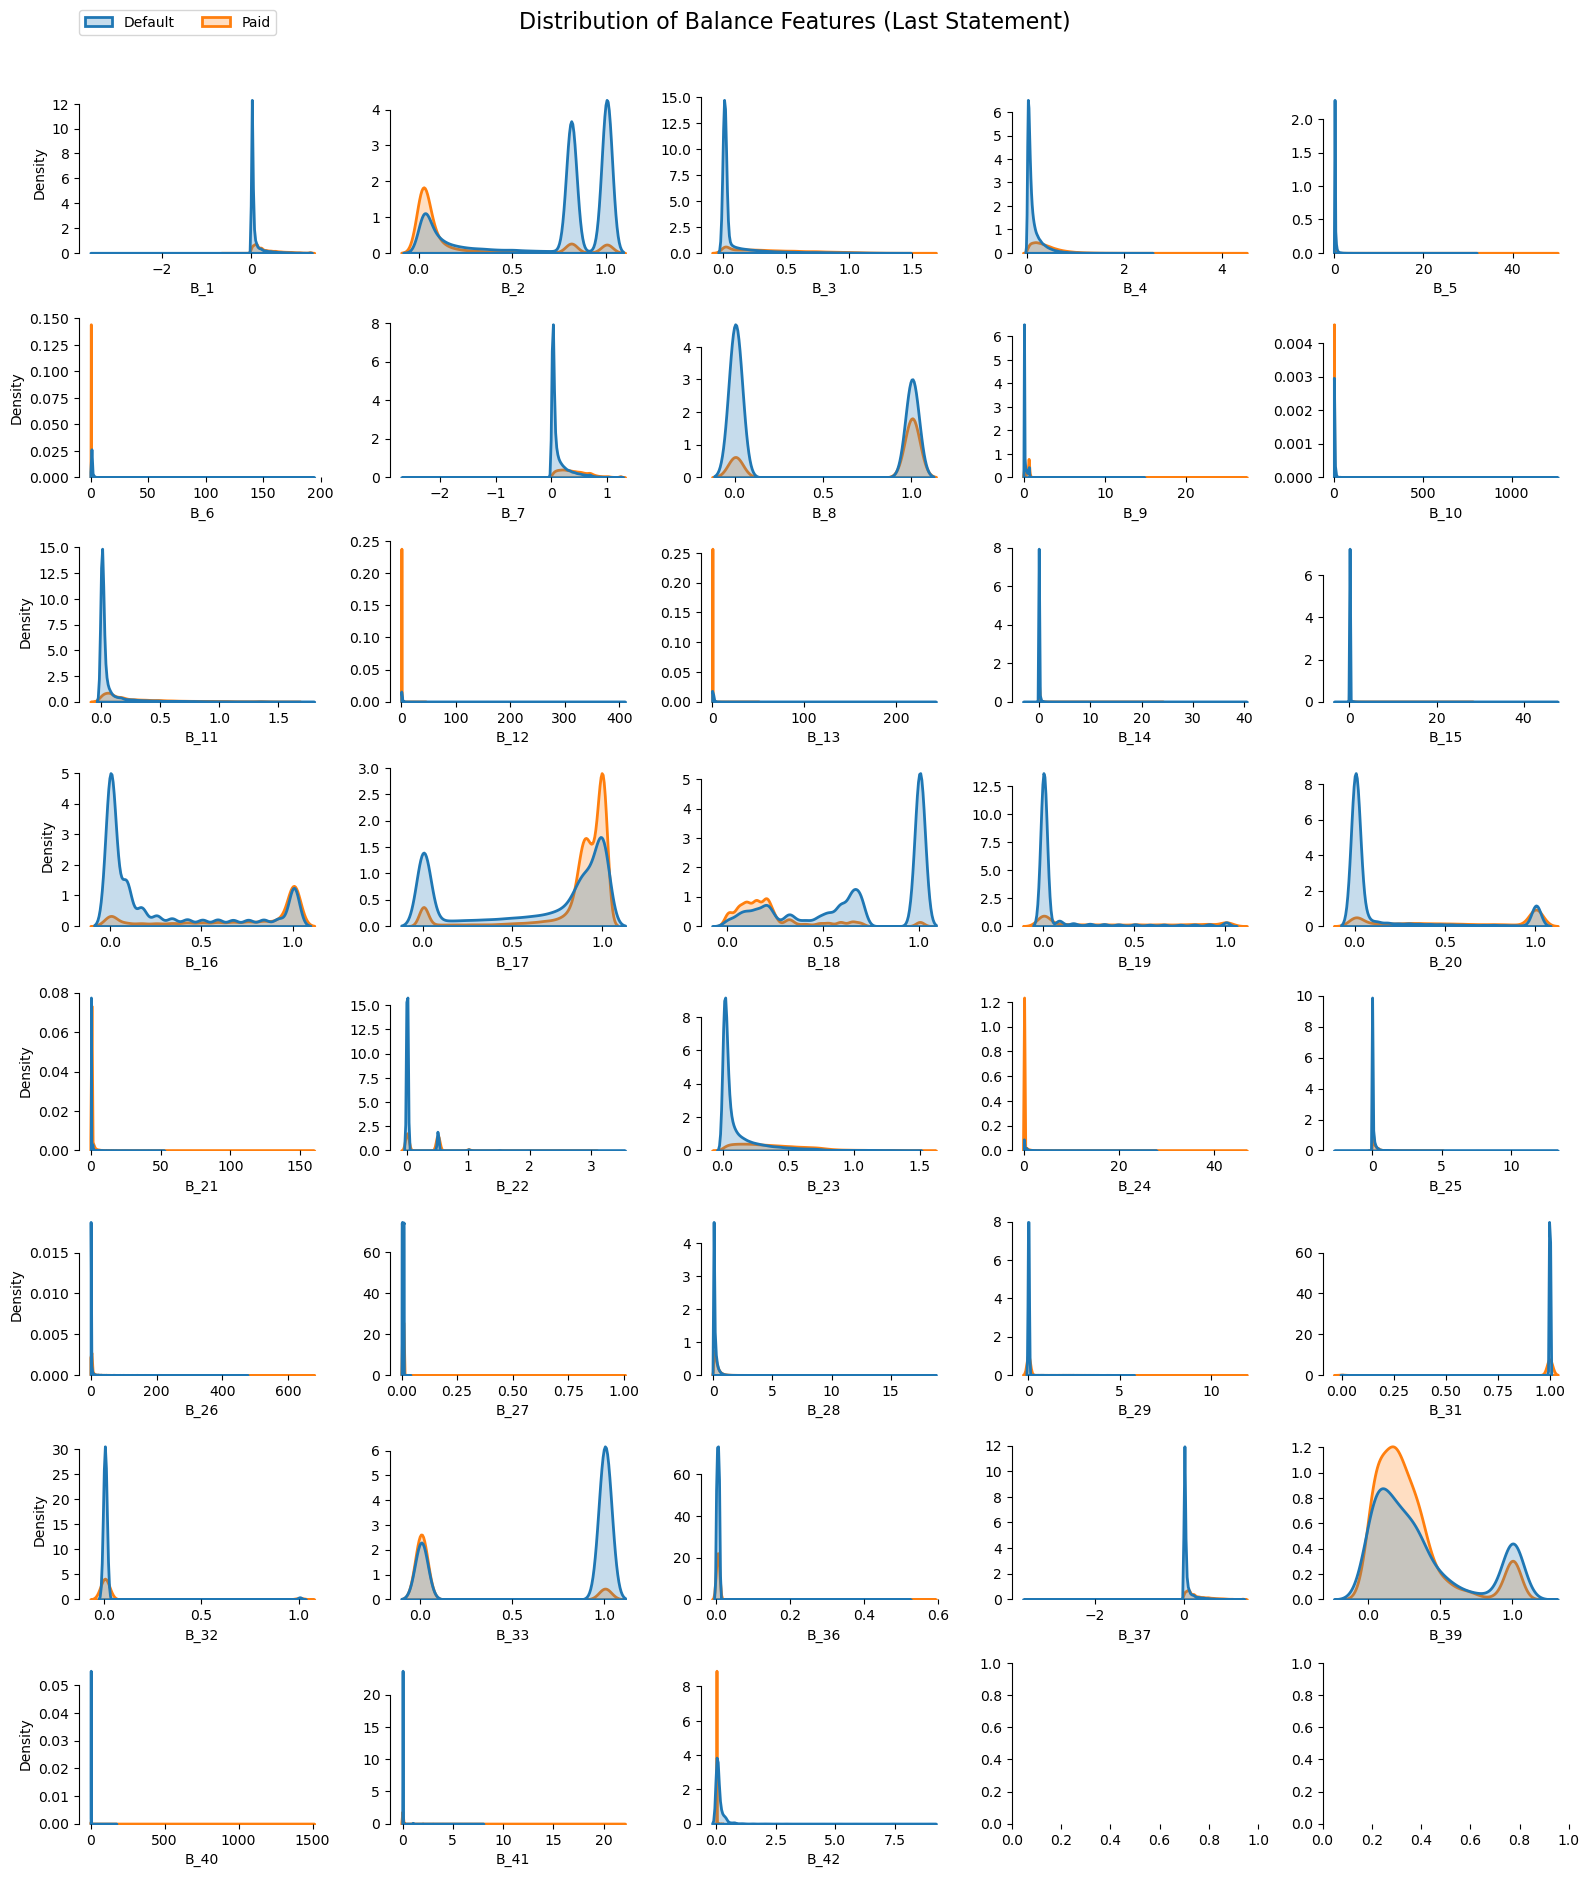

In [31]:
cols=[col for col in last_statement_df.columns if (col.startswith(('B','t'))) & (col not in cat_features)]
plot_kde_last_statement(cols, 'Distribution of Balance Features (Last Statement)')

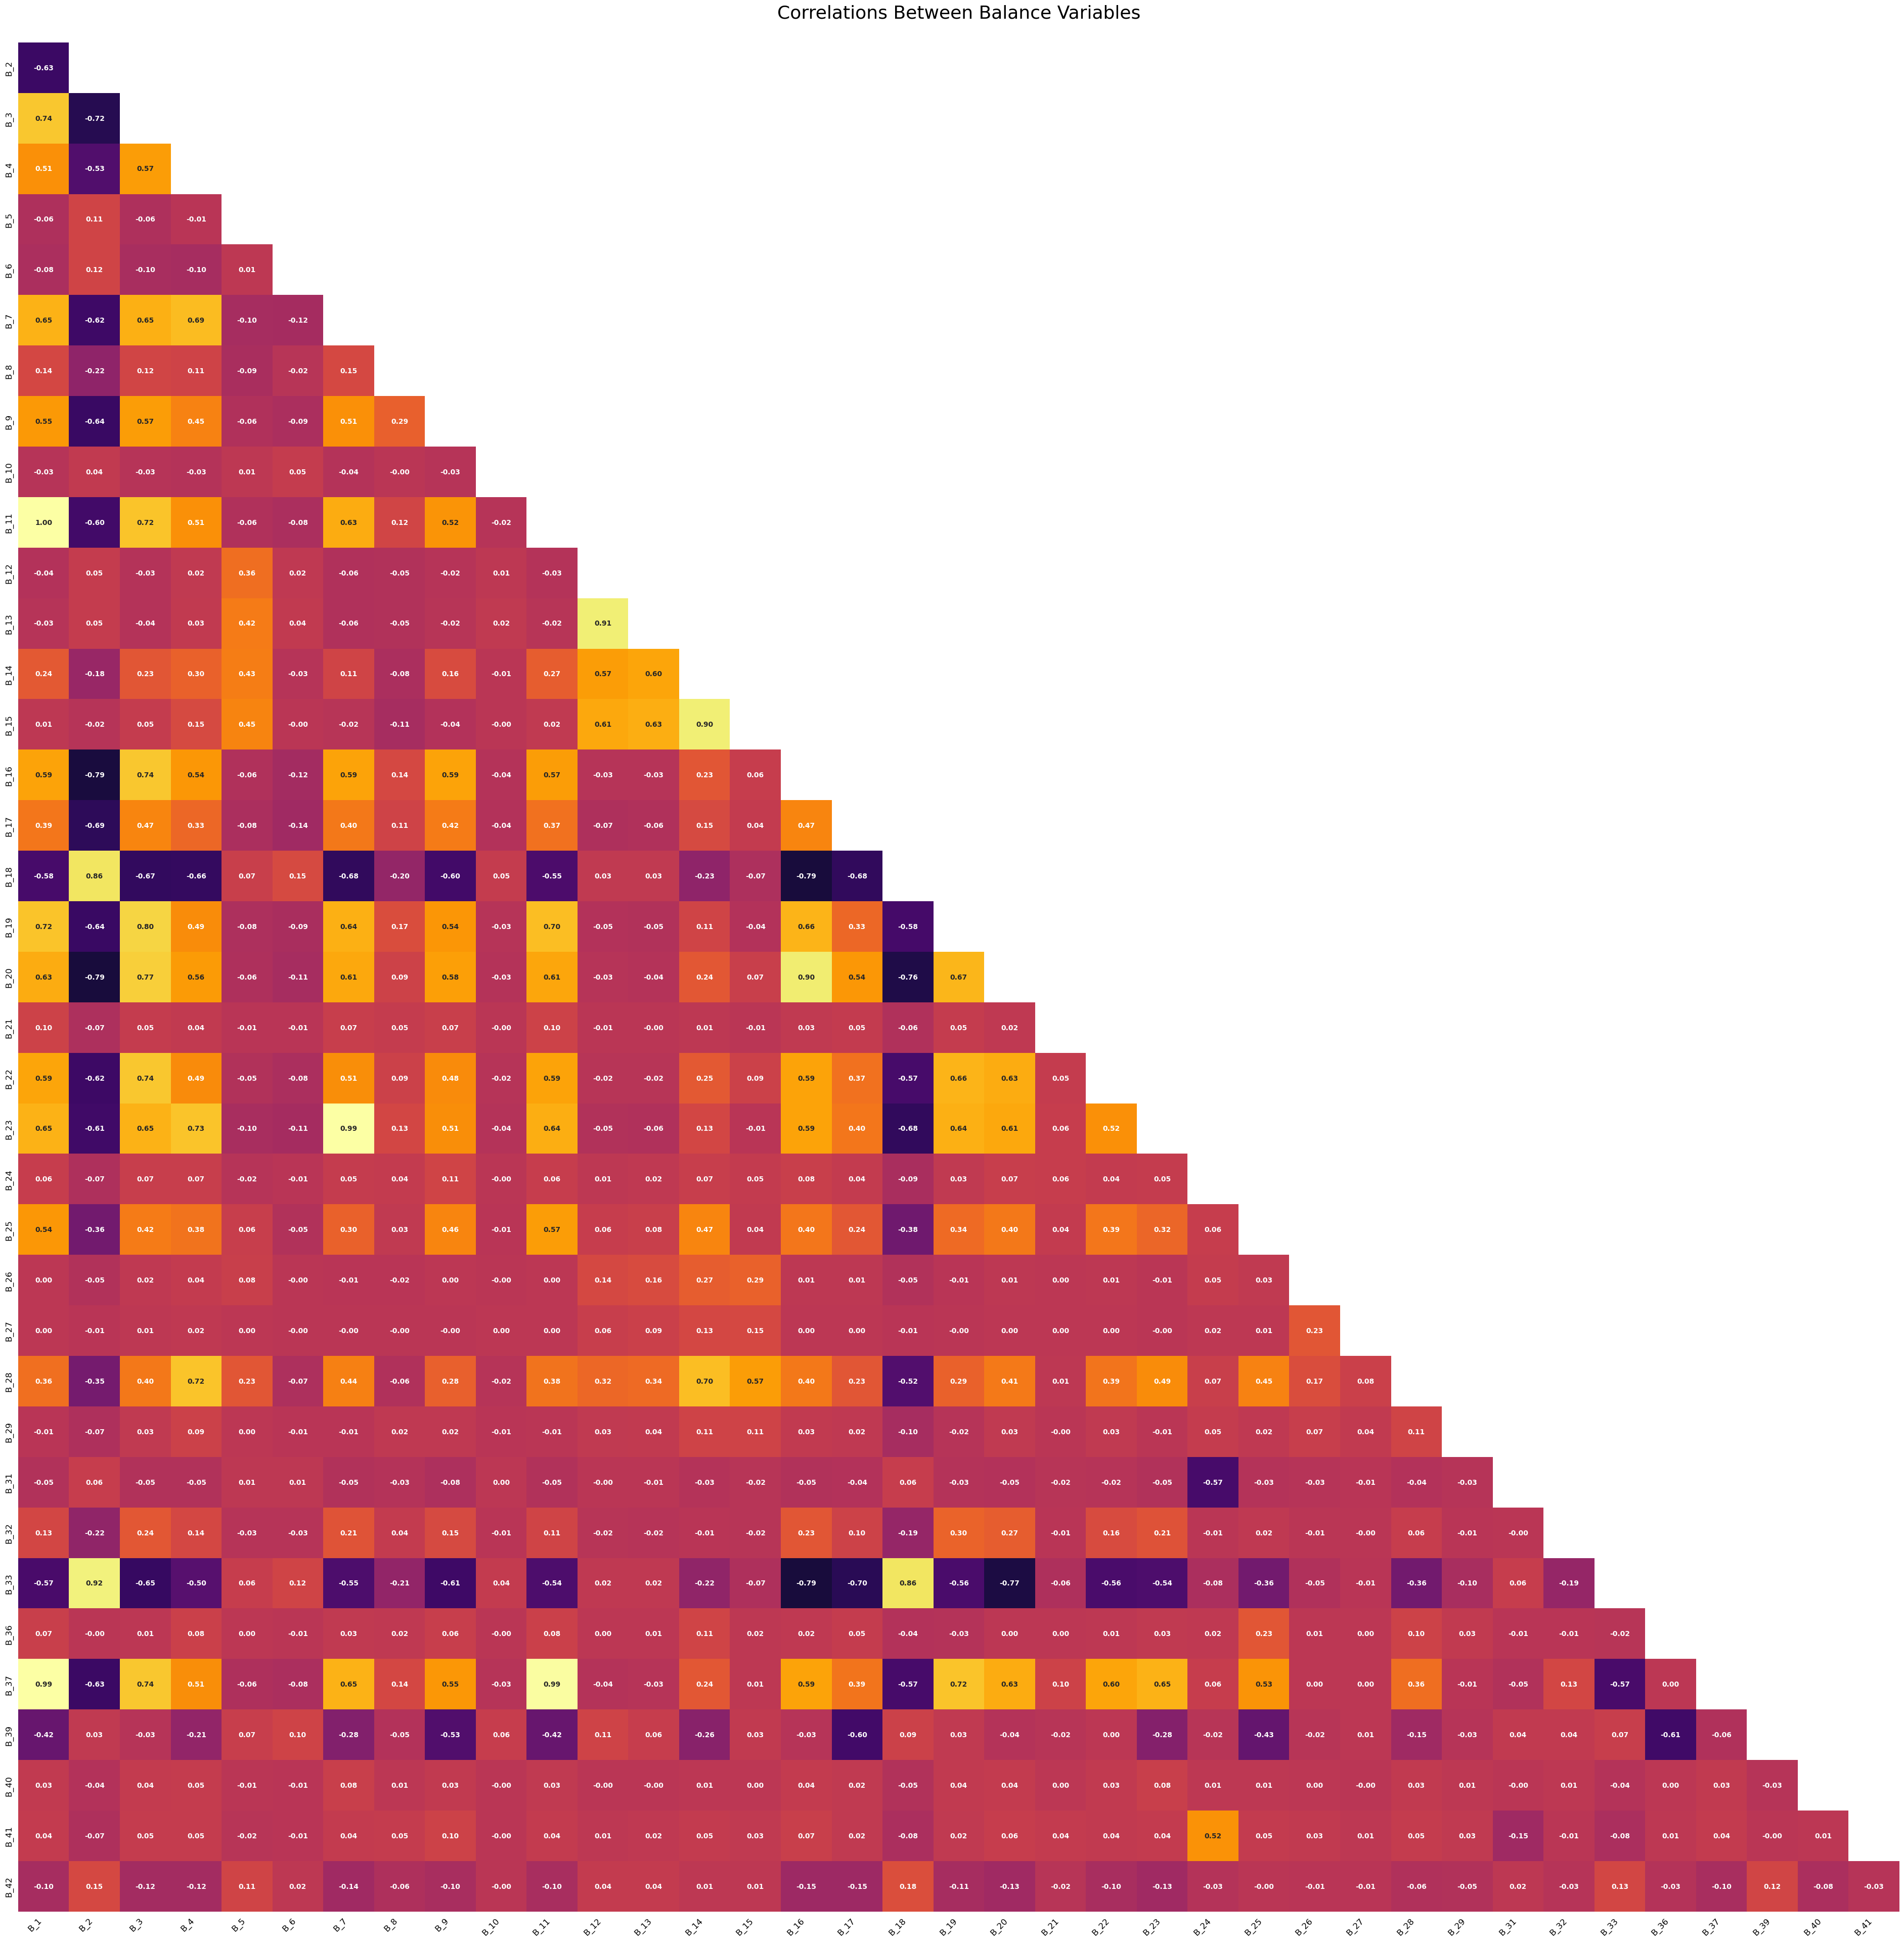

In [64]:
plot_corr_heatmap(cols, 'Correlations Between Balance Variables')

In [32]:
corr=last_statement_df[cols].iloc[:,:-1].corr()
np.fill_diagonal(corr.values, 0.0)
mask = np.triu(np.ones_like(corr, dtype=bool))
corr = corr.mask(mask)
highly_correlated_features = corr[np.abs(corr) > 0.9].stack().reset_index()
highly_correlated_features=highly_correlated_features.iloc[abs(highly_correlated_features[0]).argsort()[::-1]].reset_index()
highly_correlated_features

index level_0 level_1         0
0      0    B_11     B_1  0.995629
1      3    B_23     B_7  0.994963
2      5    B_37     B_1  0.992982
3      6    B_37    B_11  0.988209
4      4    B_33     B_2  0.918636
5      1    B_13    B_12  0.905776
6      2    B_15    B_14  0.900913

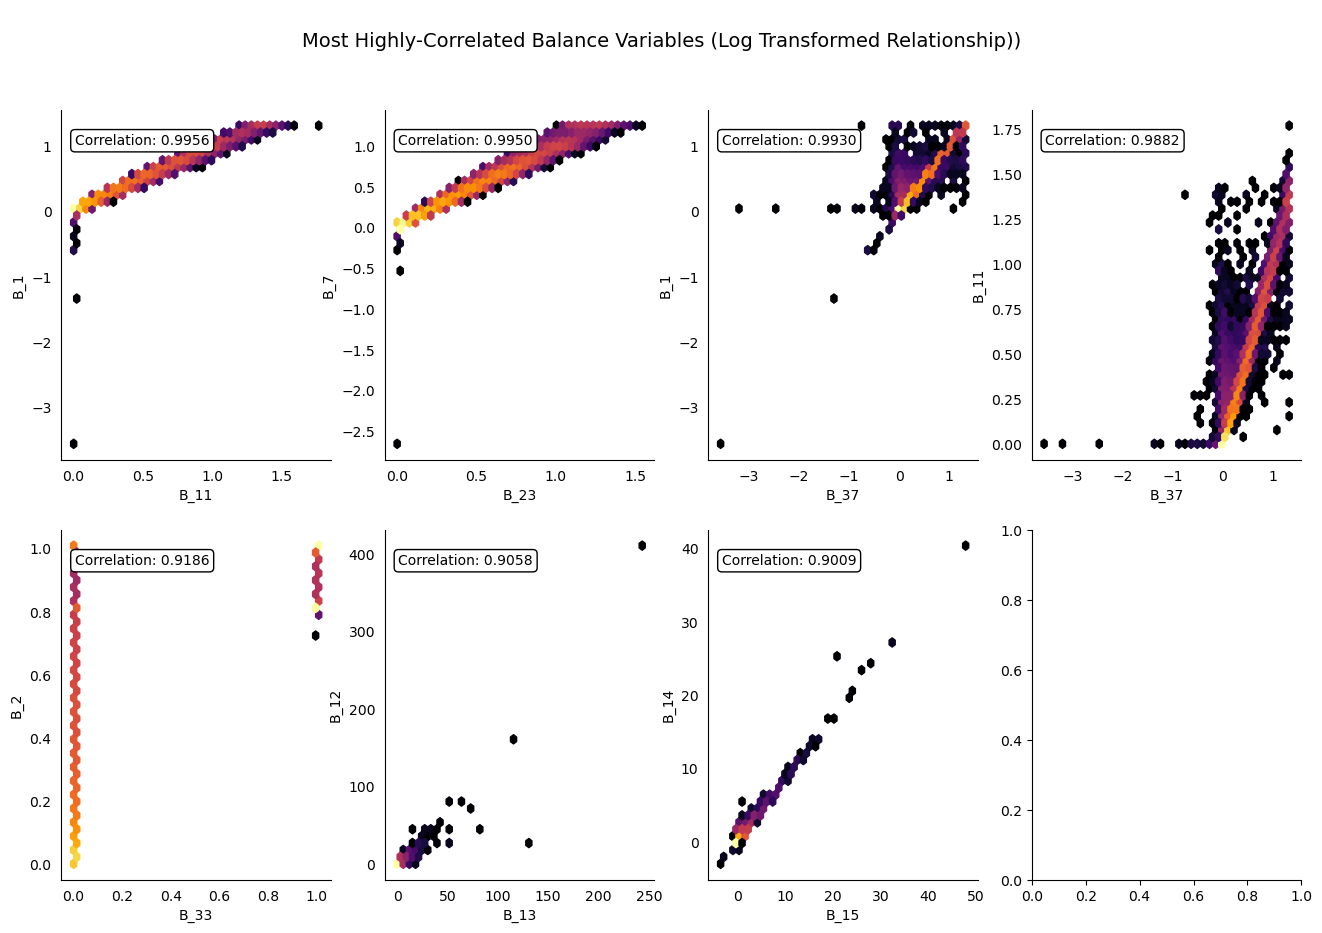

In [33]:
plot_highly_correlated_featuers(cols, 'Most Highly-Correlated Balance Variables (Log Transformed Relationship)', highly_correlated_features)

### Key Insights:


- There is 38 numerical balance features and 2 categorical balance features, some of which are highly correlated to eachother.

- They seem to have good amount of information about the target and will be included in the modelling.

- Based on the density plots, some of the variables seem to have outliers.

### 5.5.5. Risk Variables

In [39]:
risk_features = sorted([f for f in train_data.columns if (f not in ['customer_ID', 'target', 'S_2']) and (f.startswith(('R')))])
print(f"Number of risk features: {len(risk_features)}")
print(f"Number of numerical risk features: {len([f for f in risk_features if f not in cat_features])}")

Number of risk features: 28
Number of numerical risk features: 28


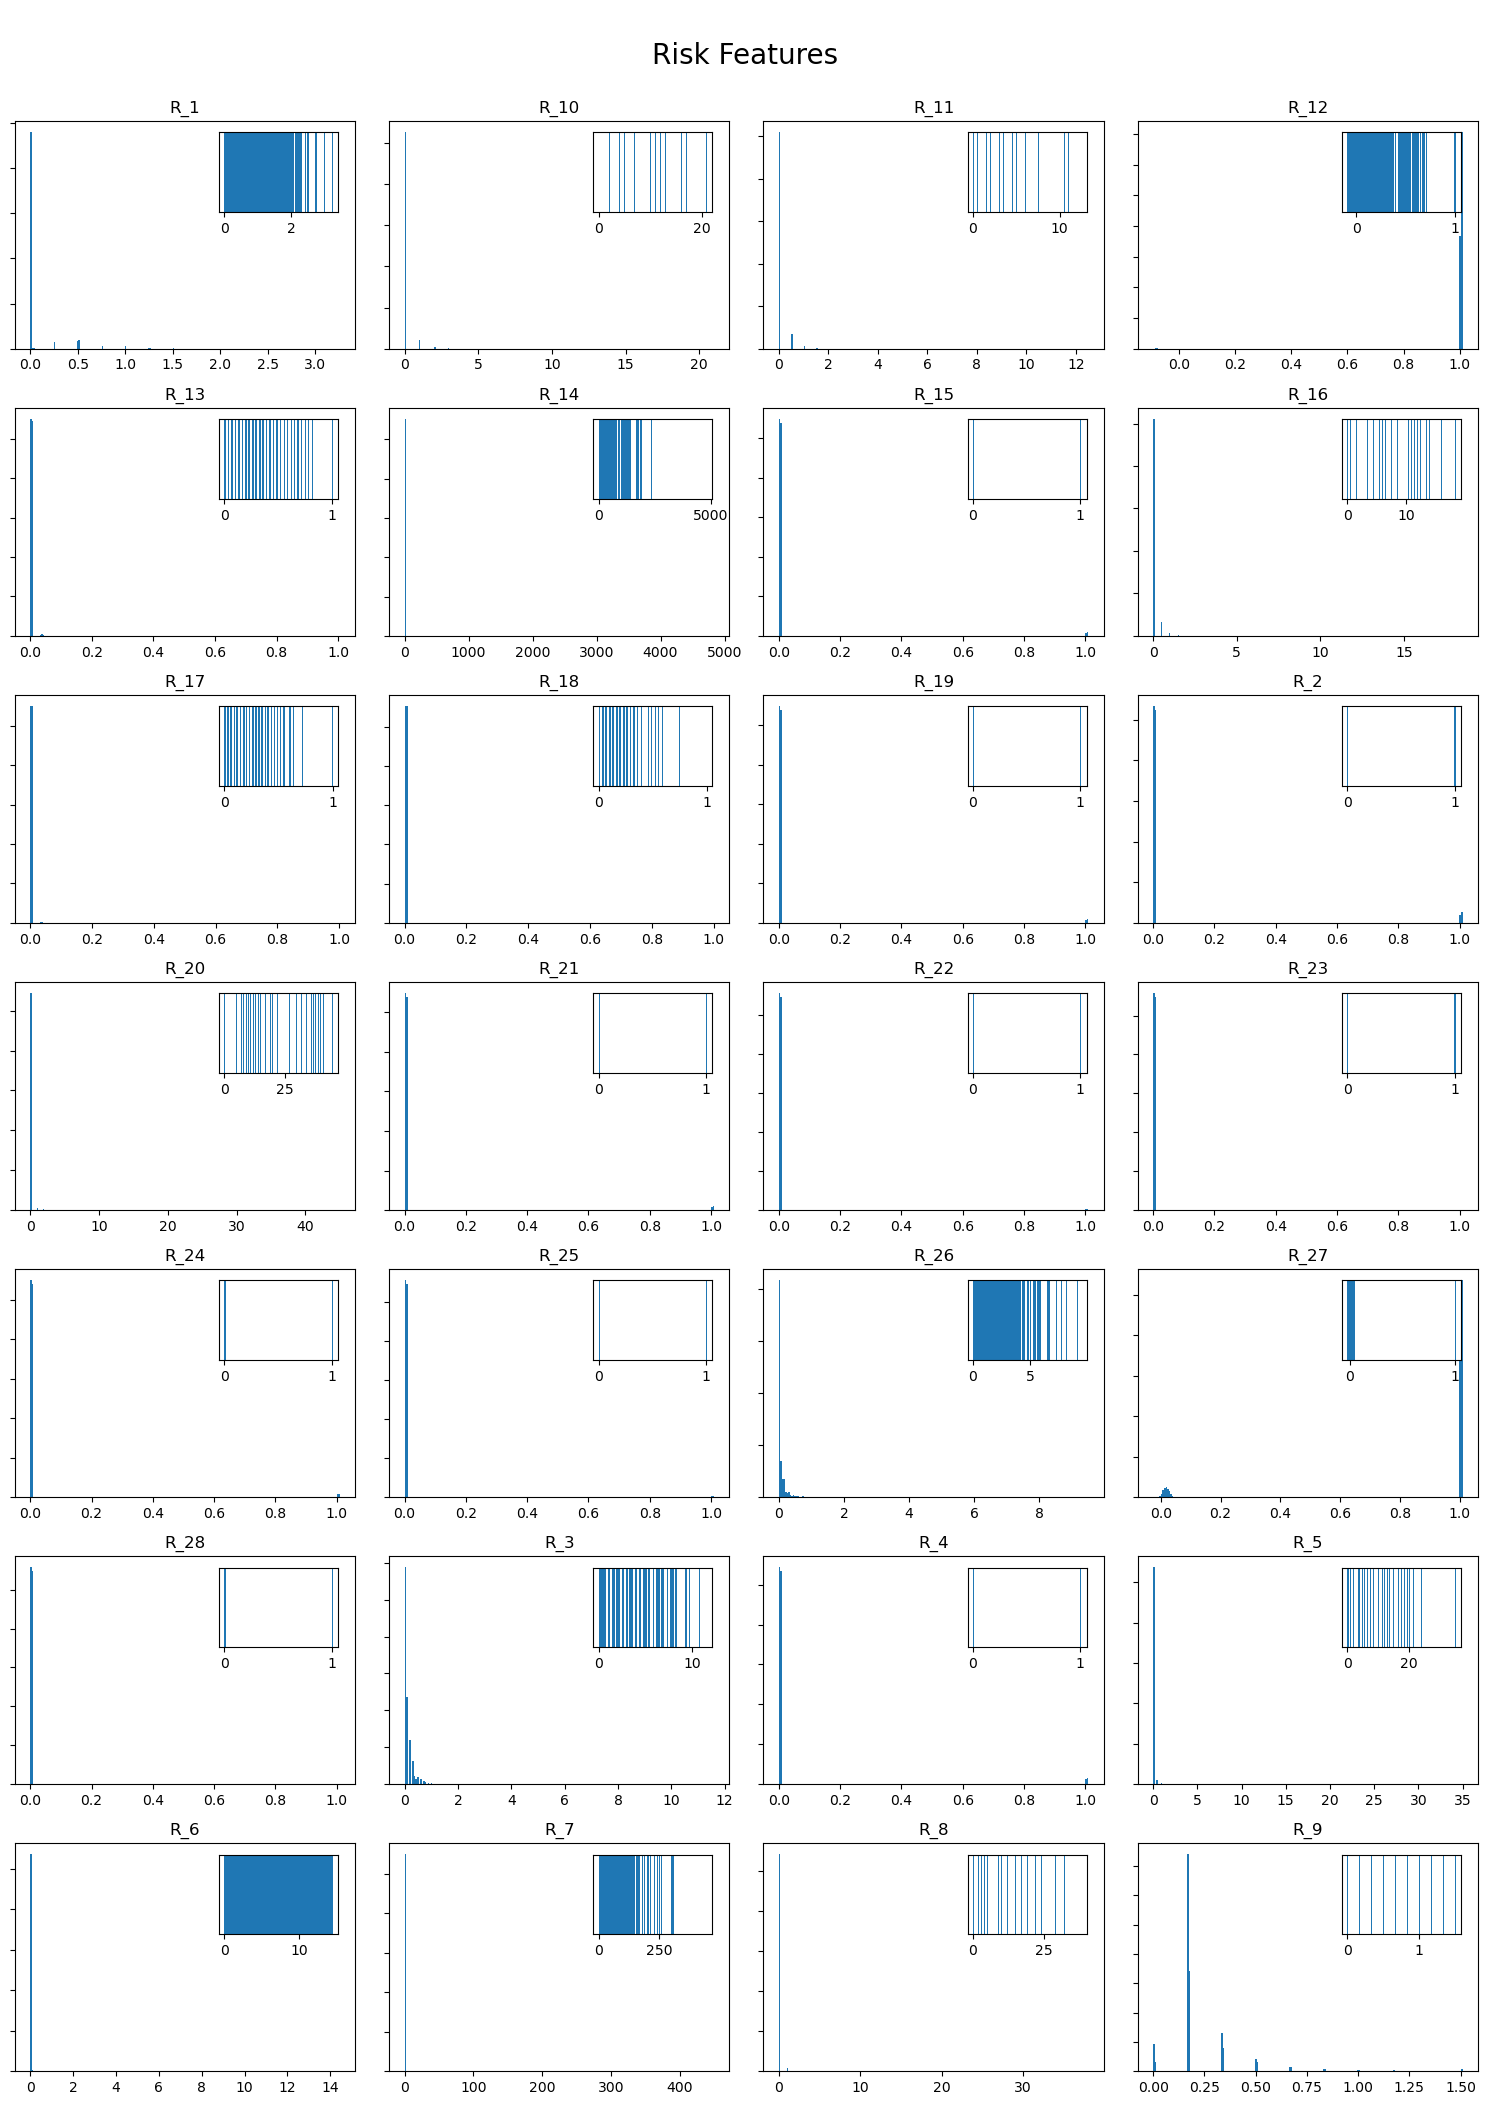

In [70]:
plot_hist(risk_features, 'Risk Features')

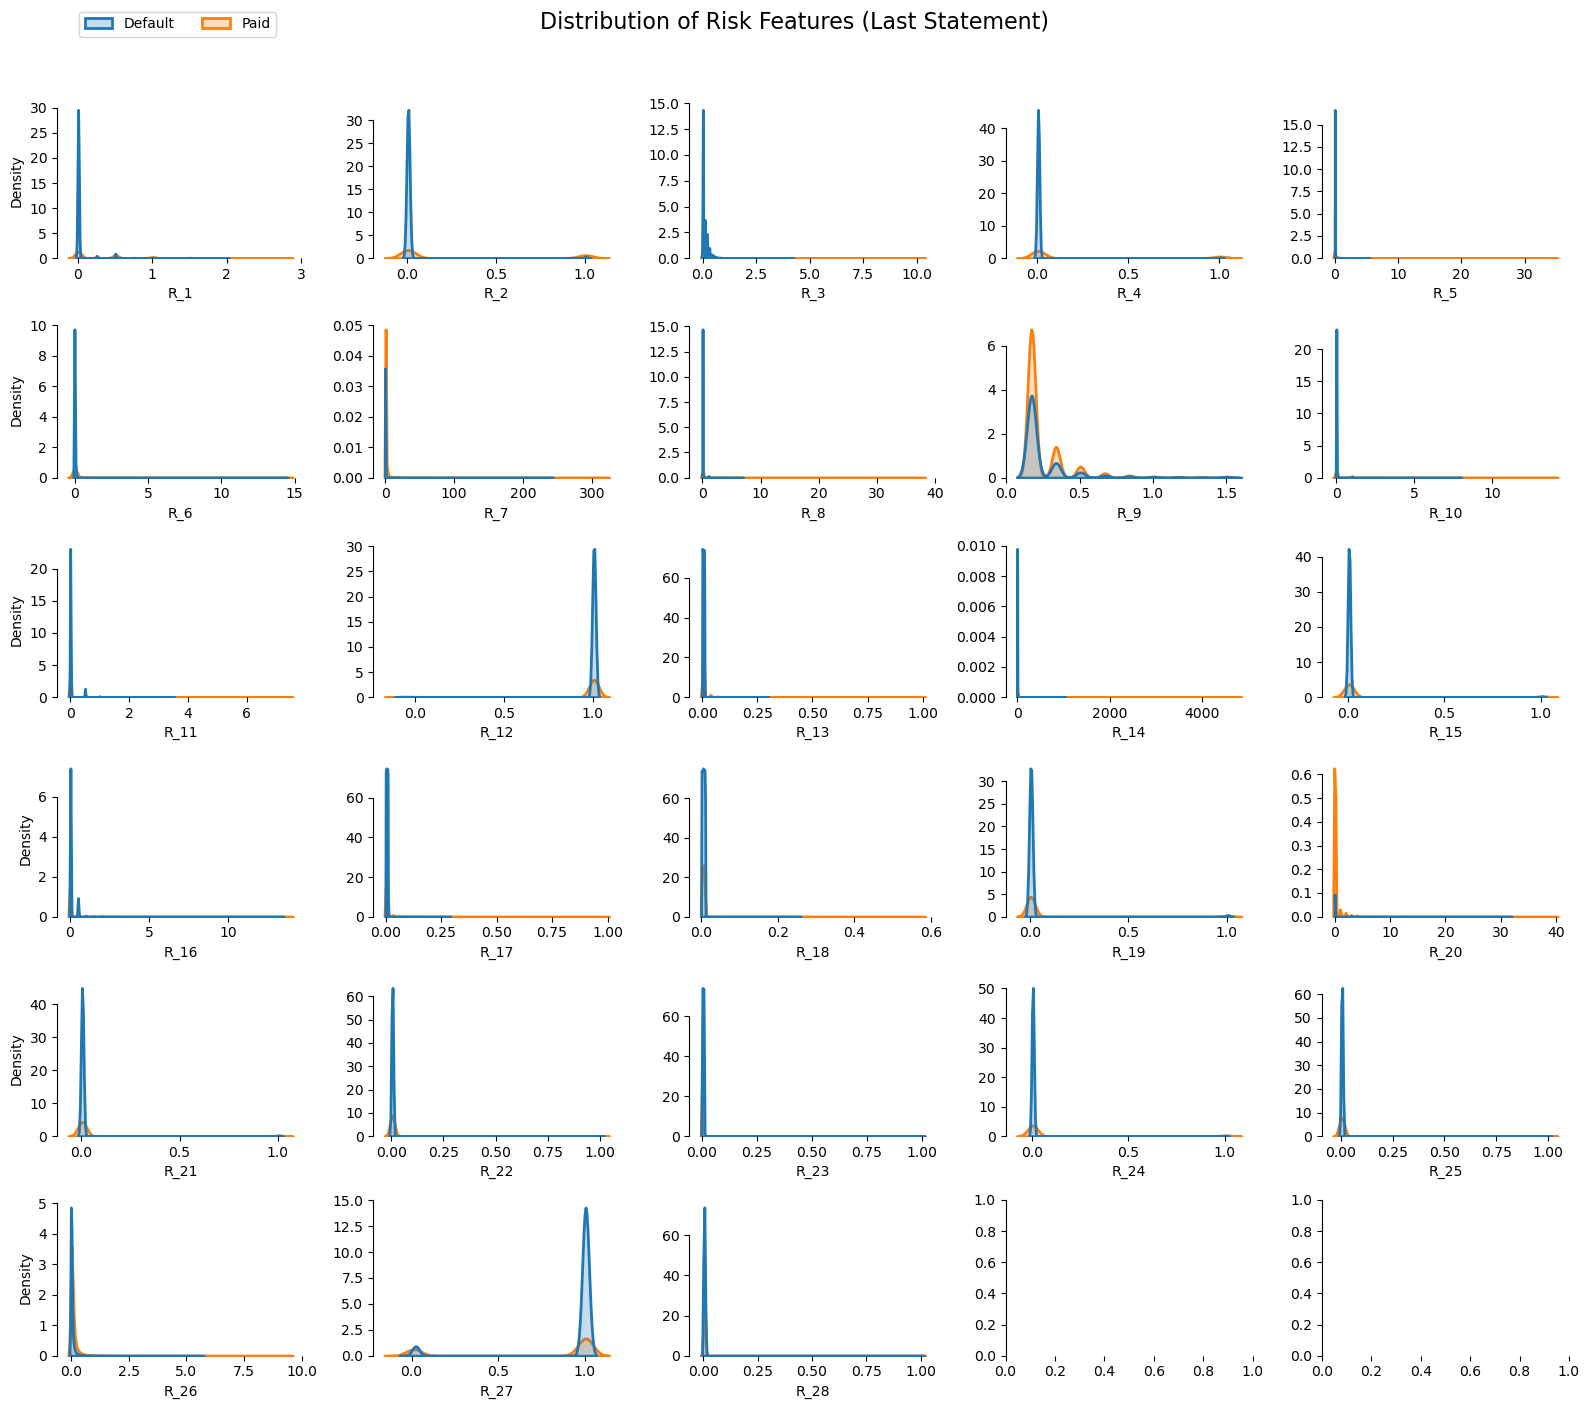

In [40]:
cols=[col for col in last_statement_df.columns if (col.startswith(('R','t'))) & (col not in cat_features)]
plot_kde_last_statement(cols, 'Distribution of Risk Features (Last Statement)')

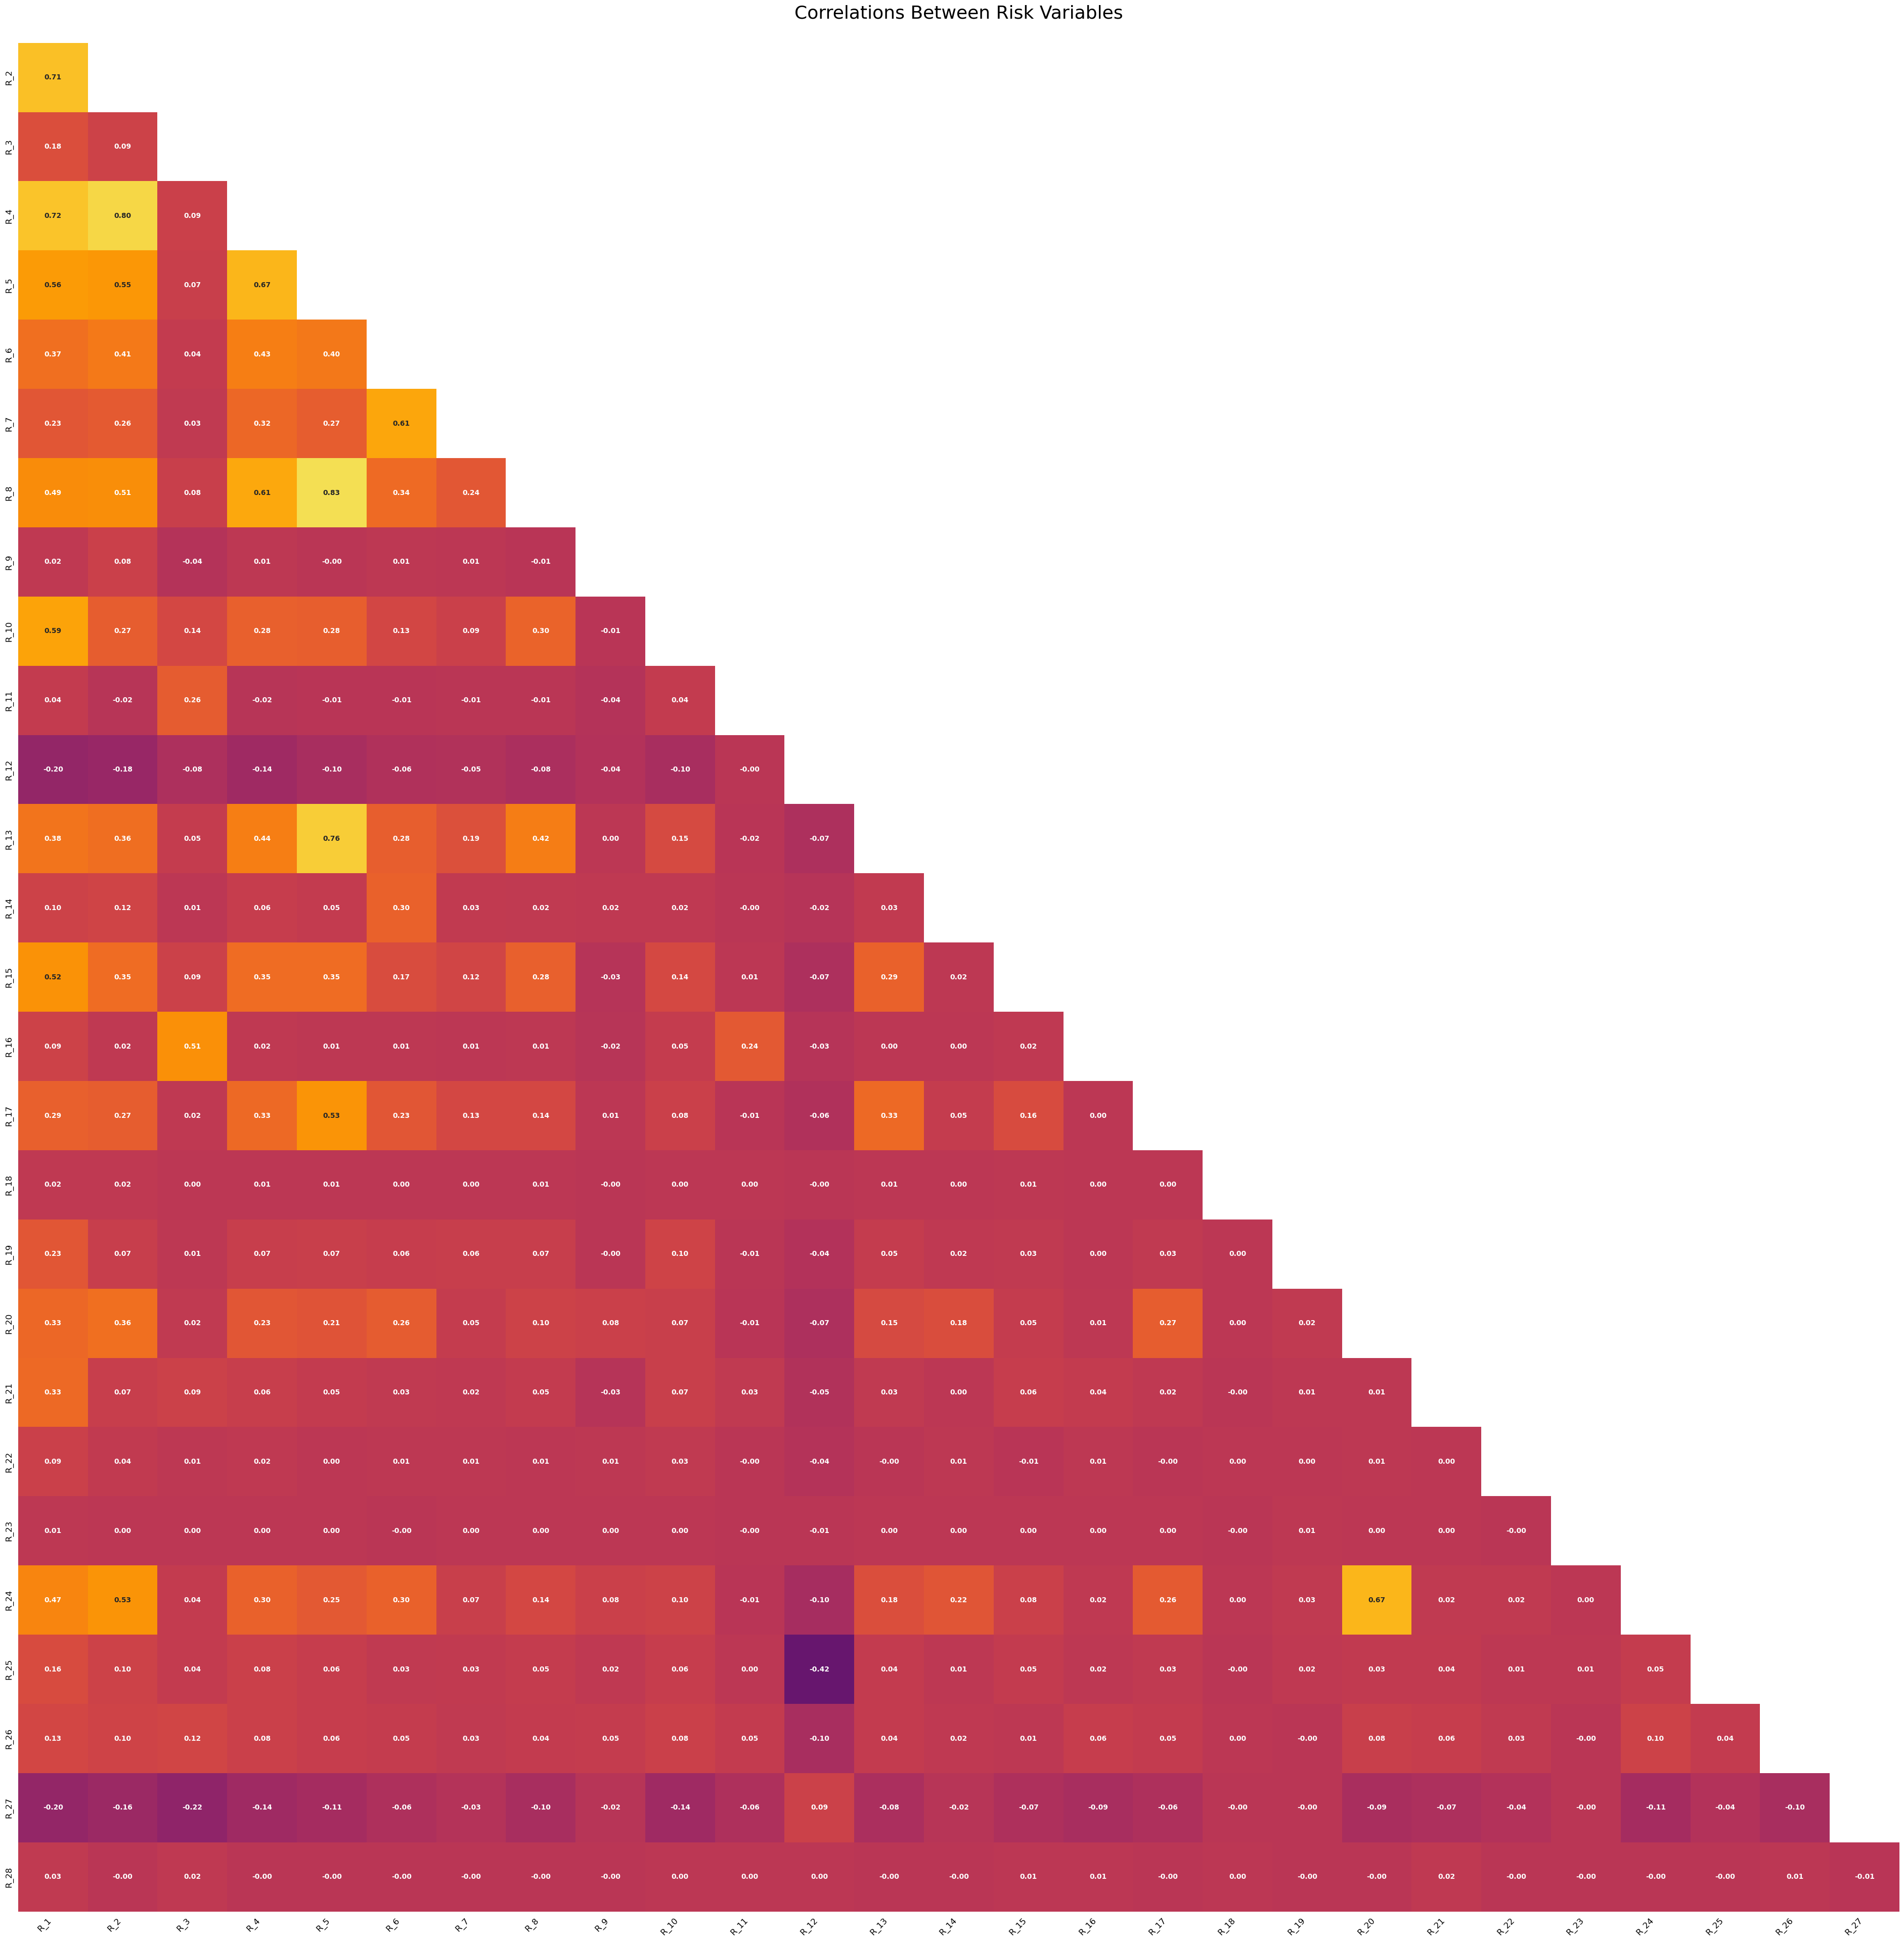

In [73]:
plot_corr_heatmap(cols, 'Correlations Between Risk Variables')

In [42]:
corr=last_statement_df[cols].iloc[:,:-1].corr()
np.fill_diagonal(corr.values, 0.0)
mask = np.triu(np.ones_like(corr, dtype=bool))
corr = corr.mask(mask)
highly_correlated_features = corr[np.abs(corr) > 0.8].stack().reset_index()
highly_correlated_features=highly_correlated_features.iloc[abs(highly_correlated_features[0]).argsort()[::-1]].reset_index()
highly_correlated_features

index level_0 level_1         0
0      0     R_8     R_5  0.831764

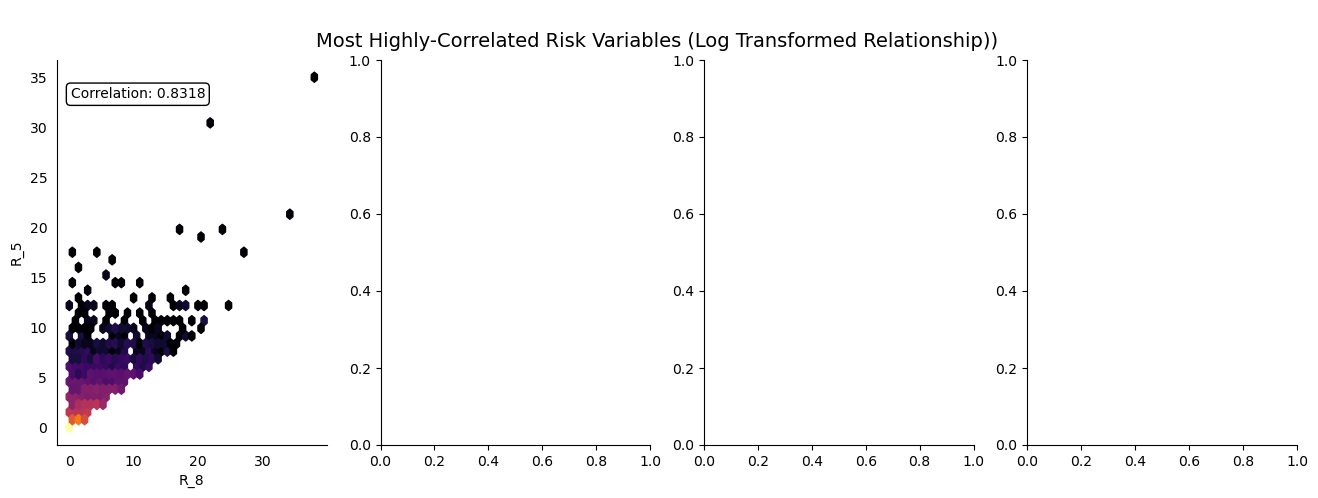

In [43]:
plot_highly_correlated_featuers(cols, "Most Highly-Correlated Risk Variables (Log Transformed Relationship)", highly_correlated_features)

### Key Insights:


- There is 28 numerical risk features and no categorical risk features.

- Most risk features are not highly correlated to eachother. The highest correlation is between R_5 and R_8.

- They seem to have good amount of information about the target and will be included in the modelling.

### 4.6. Correlation of Variables with the Target

/tmp/ipykernel_32/4117444113.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



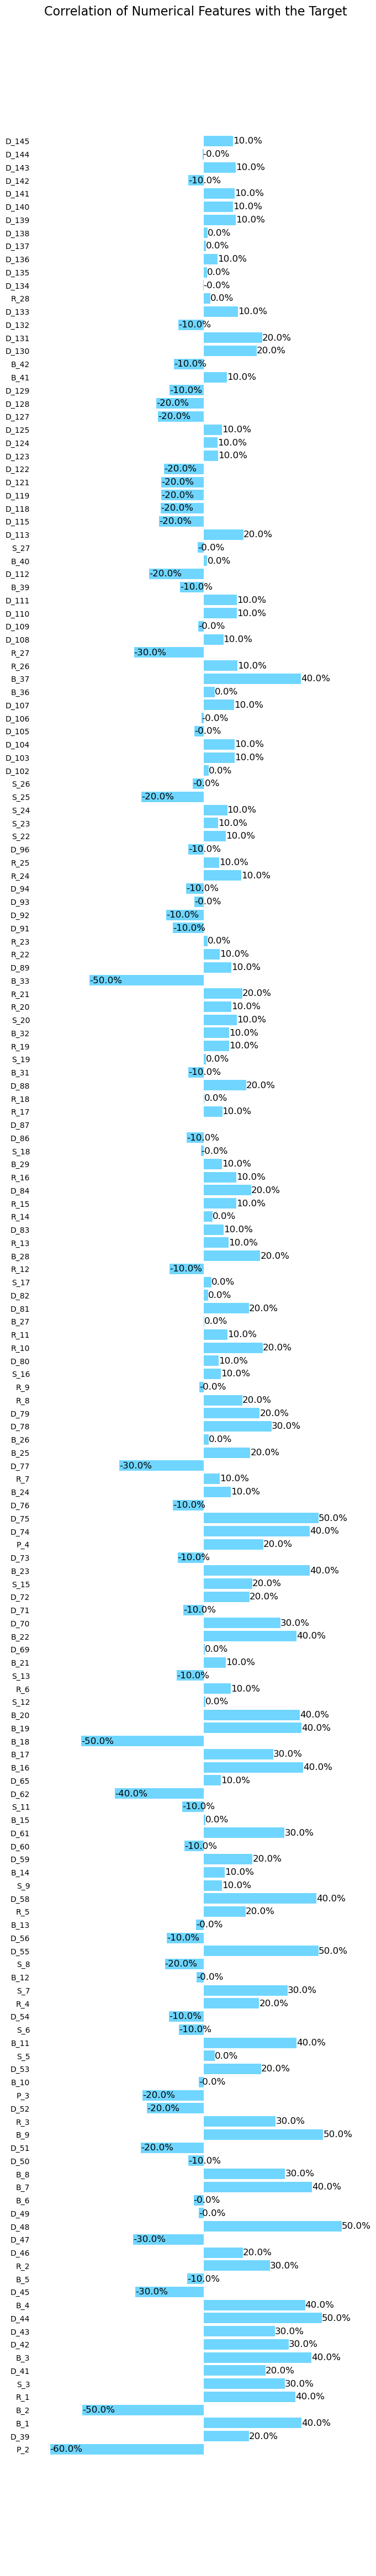

In [47]:
#train_data=train_data.drop(cat_features)
targ = train_data.iloc[:, :-1].corrwith(train_data['target'], axis=0)
val = [str(round(v ,1) *100) + '%' for v in targ.values]

fig, ax = plt.subplots(figsize=(7.5, 60))
bars = ax.barh(targ.index, targ.values, color=next(palette))

for bar, label in zip(bars, val):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, label,ha='left', va='center', fontsize=12)

ax.set_title("Correlation of Numerical Features with the Target", fontsize=16)
ax.set_facecolor('none')
ax.tick_params(axis='y', which='both', left=False)

ax.set_xticks([])
ax.set_xticklabels([])

ax.spines[['top', 'bottom', 'left', 'right']].set_visible(False)
plt.show()


In [41]:
sorted_targ = abs(targ).sort_values(ascending=False)

In [42]:
sorted_targ

P_2      0.610765
D_48     0.549362
B_18     0.487393
B_2      0.483062
B_9      0.475858
           ...   
D_69     0.004504
B_27     0.003223
D_134    0.002199
R_18     0.001811
D_87          NaN
Length: 177, dtype: float64

### Key Insights: 

- Looking at the correlation of features with the target, we see that the correlations range from -61% to 50%. 

- P_2 has the highest correlation with the target at -61%.

- It will be interesting to use the top highest correlated features for modelling and see if that leads to good results. I will explore that in my other notebook.